# Index

# Modules and tools :

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
from datetime import datetime, date, time
import os
import requests
import string
import json
import seaborn as sns
from scipy import stats
import scipy.stats as st
from scipy.stats import ttest_rel
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Introduction

### Dataset

The dataset come from two different websites, from 2001 to 2007 (17years) : https://www.ratebeer.com/ and https://www.beeradvocate.com/. This two platforms where one can review and share about beers. Technically it consists of three csv files and two txt files for each websites :
1) beers.csv : informations about the beers
2) breweries.csv : informations about the breweries
3) users.csv : informations about the users
4) rating.txt : all the different rating for each beer
5) reviews.txt : all the different review for each beer

### Import users, breweries and beers files

In [2]:
# BeerAdvocate
BA_dir = './datasets/BeerAdvocate/'
BA_users_file = f'{BA_dir}/users.csv'
BA_breweries_file = f'{BA_dir}/breweries.csv'
BA_beers_file = f'{BA_dir}/beers.csv'

# RateBeer
RB_dir = './datasets/RateBeer/'
RB_users_file = f'{RB_dir}/users.csv'
RB_breweries_file = f'{RB_dir}/breweries.csv'
RB_beers_file = f'{RB_dir}/beers.csv'

### Import reviews files

The reviews.txt files of both beer databases (BeerAdvocate and RateBeer) have proven to be too large to be store in the GitHub repository as they are, so further care had to be taken in order to unsure that the data contained in this file could still be used.

As the text files are large (more than 165 million lines combined), in order to circunvent kernel freezes and other technical problems faced during the data analysis, we decided to split the parsed json files and zip them before loading them to memory in the pandas DataFrames. The splitting of the files is handled automatically in the /parse_reviews/parse_reviews_with_file_split.py python script, and the splitted datasets are loaded separetely.

#### BeerAdvocate

In [3]:
BA_reviews = pd.read_json('./parse_reviews/part_2_BeerAdvocate.json.zip')
BA_reviews = BA_reviews.drop_duplicates(subset=['beer_id', 'user_id'], keep='first')
BA_reviews.head(1)

,beer_id,brewery_id,style,user_id,rating
0,142544,37262,Euro Pale Lager,nmann08.184925,2.88


In [4]:
# Add the missing columns on the dataframe
BA_reviews_0 = pd.read_json('./datasets/all_reviews/0_part_3_BeerAdvocate.json.zip')
BA_reviews_1 = pd.read_json('./datasets/all_reviews/1_part_3_BeerAdvocate.json.zip')
BA_reviews_2 = pd.read_json('./datasets/all_reviews/2_part_3_BeerAdvocate.json.zip')

In [5]:
BA_reviews_3 = pd.read_json('./datasets/all_reviews/3_part_3_BeerAdvocate.json.zip')
BA_reviews_4 = pd.read_json('./datasets/all_reviews/4_part_3_BeerAdvocate.json.zip')
BA_reviews_5 = pd.read_json('./datasets/all_reviews/5_part_3_BeerAdvocate.json.zip')

In [6]:
BA_reviews_next = pd.concat([BA_reviews_0, BA_reviews_1, BA_reviews_2, BA_reviews_3, BA_reviews_4, BA_reviews_5])
BA_reviews_next = BA_reviews_next.drop_duplicates(subset=['beer_id', 'user_id'], keep='first')
BA_reviews_next.head(1)

,beer_name,beer_id,user_name,user_id,appearance,aroma,palate,taste,overall
0,Régab,142544.0,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0


In [7]:
# Create BA_reviews with all the columns
BA_reviews = BA_reviews.merge(BA_reviews_next)
print(f'number of reviews from BeerAdvocate = {len(BA_reviews)}')
BA_reviews.head(1)

number of reviews from BeerAdvocate = 2589586


,beer_id,brewery_id,style,user_id,rating,beer_name,user_name,appearance,aroma,palate,taste,overall
0,142544,37262,Euro Pale Lager,nmann08.184925,2.88,Régab,nmann08,3.25,2.75,3.25,2.75,3.0


#### RateBeer

In [8]:
RB_reviews_0 = pd.read_json('./datasets/all_reviews/0_part_2_RateBeer.json.zip')
RB_reviews_1 = pd.read_json('./datasets/all_reviews/1_part_2_RateBeer.json.zip')
RB_reviews_2 = pd.read_json('./datasets/all_reviews/2_part_2_RateBeer.json.zip')
RB_reviews_3 = pd.read_json('./datasets/all_reviews/3_part_2_RateBeer.json.zip')
RB_reviews = pd.concat([RB_reviews_0, RB_reviews_1, RB_reviews_2, RB_reviews_3])
RB_reviews = RB_reviews.drop_duplicates(subset=['beer_id', 'user_id'], keep='first')
RB_reviews.head(1)

,beer_id,brewery_id,style,user_id,rating
0,410549.0,3198.0,Pale Lager,175852.0,2.0


In [9]:
# Add the missing columns on the dataframe
RB_reviews_0 = pd.read_json('./datasets/all_reviews/0_part_3_RateBeer.json.zip')
RB_reviews_1 = pd.read_json('./datasets/all_reviews/1_part_3_RateBeer.json.zip')
RB_reviews_2 = pd.read_json('./datasets/all_reviews/2_part_3_RateBeer.json.zip')

In [10]:
RB_reviews_3 = pd.read_json('./datasets/all_reviews/3_part_3_RateBeer.json.zip')
RB_reviews_4 = pd.read_json('./datasets/all_reviews/4_part_3_RateBeer.json.zip')
RB_reviews_5 = pd.read_json('./datasets/all_reviews/5_part_3_RateBeer.json.zip')

In [11]:
RB_reviews_6 = pd.read_json('./datasets/all_reviews/6_part_3_RateBeer.json.zip')
RB_reviews_7 = pd.read_json('./datasets/all_reviews/7_part_3_RateBeer.json.zip')

In [12]:
RB_reviews_8 = pd.read_json('./datasets/all_reviews/8_part_3_RateBeer.json.zip')
RB_reviews_9 = pd.read_json('./datasets/all_reviews/9_part_3_RateBeer.json.zip')

In [13]:
RB_reviews_next = pd.concat([RB_reviews_0, RB_reviews_1, RB_reviews_2, RB_reviews_3, RB_reviews_4, RB_reviews_5, RB_reviews_6, RB_reviews_7, RB_reviews_8, RB_reviews_9])
RB_reviews_next = RB_reviews_next.drop_duplicates(subset=['beer_id', 'user_id'], keep='first')
RB_reviews_next.head(1)

,beer_name,beer_id,user_name,user_id,appearance,aroma,palate,taste,overall
0,33 Export (Gabon),410549.0,Manslow,175852.0,2.0,4.0,2.0,4.0,8.0


In [14]:
# Create RB_reviews with all the columns
RB_reviews = RB_reviews.merge(RB_reviews_next)
print(f'number of reviews from RateBeer = {len(RB_reviews)}')
RB_reviews.head(1)

number of reviews from RateBeer = 7121988


,beer_id,brewery_id,style,user_id,rating,beer_name,user_name,appearance,aroma,palate,taste,overall
0,410549.0,3198.0,Pale Lager,175852.0,2.0,33 Export (Gabon),Manslow,2.0,4.0,2.0,4.0,8.0


### Is it too big ?

One thing to consider when handling large dataset is there size, here we will try to see if it's problem.

Here we will only look for the beers, breweries and users files of each website. In the following we will also use the reviews files but those files were too big as we explained before.

In [15]:
def file_sizeMB(file_name):
    stat = os.stat(file_name)
    return stat.st_size / (1024*1024)

complete_size = 0

# For BeerAdvocate
for filename in os.listdir(BA_dir):
    file = os.path.join(BA_dir, filename)
    if os.path.isfile(file):
        print(f'{file} size in MegaBytes is {file_sizeMB(str(file))}')
        complete_size += file_sizeMB(str(file))
# For RateBeer
for filename in os.listdir(RB_dir):
    file = os.path.join(RB_dir, filename)
    if os.path.isfile(file):
        print(f'{file} size in MegaBytes is {file_sizeMB(str(file))}')
        complete_size += file_sizeMB(str(file))


print(complete_size)

./datasets/BeerAdvocate/BA_reviews.tar.gz size in MegaBytes is 71.24130630493164
./datasets/BeerAdvocate/beers.csv size in MegaBytes is 28.51298713684082
./datasets/BeerAdvocate/breweries.csv size in MegaBytes is 0.7867345809936523
./datasets/BeerAdvocate/reviews_sample.txt size in MegaBytes is 66.88321495056152
./datasets/BeerAdvocate/users.csv size in MegaBytes is 9.446638107299805
./datasets/RateBeer/beers.csv size in MegaBytes is 45.43974685668945
./datasets/RateBeer/breweries.csv size in MegaBytes is 1.013178825378418
./datasets/RateBeer/RB_reviews_1.tar.gz size in MegaBytes is 84.52471446990967
./datasets/RateBeer/RB_reviews_2.tar.gz size in MegaBytes is 67.54720973968506
./datasets/RateBeer/reviews_sample.txt size in MegaBytes is 0.025028228759765625
./datasets/RateBeer/users.csv size in MegaBytes is 3.1213817596435547
378.54214096069336


The file size of each dataset and format (.csv) can be handle pretty easily without any particular issues that we can think of.

### What's the model of our data and what's in it?

Let's take a look at the data given by BeerAdvocate :

In [16]:
user_ba = pd.read_csv(BA_users_file)
user_ba.head(10)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,1.199704e+09,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,Northern Ireland
5,2326,0,hellpop65.48993,Hellpop65,1.131966e+09,"United States, Kansas"
6,3098,0,latarnik.52897,Latarnik,1.133521e+09,"United States, New Jersey"
7,1866,23,rochefortchris.697017,RochefortChris,1.349172e+09,"United States, North Carolina"
8,1131,188,okcnittany.144868,OKCNittany,1.182766e+09,"United States, Oklahoma"
9,9987,16,jaydoc.265507,jaydoc,1.226488e+09,"United States, Kansas"


In [17]:
beers_ba = pd.read_csv(BA_beers_file)
beers_ba.head(10)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN
5,166068,Arpa,39913,Arpa (АРПА),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
6,166071,Eles,39914,Bear Beer,Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
7,166072,Eles Light,39914,Bear Beer,Euro Pale Lager,0,0,NaN,NaN,NaN,3.2,NaN,NaN,0,NaN
8,166074,Toroz Svetloye,39914,Bear Beer,American Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN
9,166076,Toroz Temnoye,39914,Bear Beer,Euro Dark Lager,0,0,NaN,NaN,NaN,4.1,NaN,NaN,0,NaN


In [18]:
breweries_ba = pd.read_csv(BA_breweries_file)
breweries_ba.head(10)

,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2
5,16051,Kyrgyzstan,Pivzavod Uzgen,0
6,16052,Kyrgyzstan,Steinbrau Pub,4
7,39917,Kyrgyzstan,Usu-Salkin Pivo,3
8,37262,Gabon,Societe des Brasseries du Gabon (SOBRAGA),1
9,10093,Northern Ireland,Strangford Lough Brewing Company Ltd,5


As we can see it seems that the data are stored in a relational model (i.e., the index ```brewery_id``` in the beers.csv dataset is the foreign key that point to the primary key ```id``` in the breweries.csv. 

We can confirm our observation with a prelimenary check on the name of the brewery for the first row of ```beer_ba```: 

In [19]:
beers_ba.iloc[0].brewery_name == breweries_ba[breweries_ba.id == beers_ba.iloc[0].brewery_id].name

0    True
Name: name, dtype: bool

Ok so we have our first confirmation, we should make sure that there is no problem with the attribution of the key by performing the test for each rows but for now let assume there is no issues.

Concerning what's in the data we can see that for the breweries and users dataset the name colunm are pretty straightforward and speaks for itself. Concerning the beers dataset some name colunm are understandable by themself and other don't. For now there is a lot of NaN values (one thing to notice is that even if a beer doesn't have rating it is still in the dataset). Maybe looking at other value will help understand.

In [20]:
beers_ba[~beers_ba.isna().any(axis=1)].head()

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
25,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,English Pale Ale,75,59,3.45,80.0,80.0,4.8,3.439867,-0.649167,59,3.504068
27,20842,St. Patrick's Best,10093,Strangford Lough Brewing Company Ltd,English Bitter,64,48,3.56,82.0,90.0,4.2,3.556094,-0.478579,48,3.580417
3231,18650,Tawny Owl,6872,Cotleigh Brewery,English Bitter,20,16,3.71,84.0,80.0,3.8,3.707000,-0.216512,16,3.680625
6185,21,Deep Shaft Stout,18,Freeminer Brewery Ltd.,Foreign / Export Stout,66,66,4.25,90.0,94.0,6.2,4.254848,0.751762,66,4.254848
6194,856,Shakemantle Ginger Ale,18,Freeminer Brewery Ltd.,Herbed / Spiced Beer,12,12,3.75,84.0,86.0,5.0,3.750000,-0.128881,12,3.750000


1) ```avg``` is the the average rating out of 5 showing in the website for a particular beer.
2) ```avg_computed``` is the average score out of 5 computed with the combination of a weighted sum of the 5 different aspect of rating
3) ```zscore``` is the standardized score to compare the two website used in this paper https://dlab.epfl.ch/people/west/pub/Lederrey-West_WWW-18.pdf

# 0. Data cleaning

### Helper functions:

In [21]:
def transform_values(df):
    try:
        df['user_id'] = df['user_id'].astype(int)
    except:
        df['user_id'] = df['user_id'].apply(lambda x: str(x).strip())

    for field in ['beer_name', 'brewery_name', 'style']:
        df[field] = df[field].apply(lambda x: str(x).strip())
    for column_name in ['brewery_id', 'beer_id']:
        df[column_name] = df[column_name].astype(int)
    for column_name in ['abv', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']:
        df[column_name] = df[column_name].astype(float)
    df['review'] = df['review'].astype(bool)

    df['date'] = df['date'].apply(lambda x: datetime.fromtimestamp(int(x)))
    return df


def read_full_reviews_file(csv_file):
    colnames = ['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv', 'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']
    df = pd.read_csv(csv_file, sep='\|\|\|', names=colnames, engine='python')
    return df


def read_sample_reviews_file(file_path):
    def parse_dict(lines):
        result = {}
        for line in lines:
            key, value = line.split(':', 1)
            value = value.split('\n')[0]
            result[key] = value
        return result


    with open(file_path, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    blank_lines_indexes = [index for index, line in enumerate(lines) if line.isspace()]

    data = []
    begin_index = 0
    for end_index in blank_lines_indexes:
        result_dict = parse_dict(lines[begin_index:end_index])
        data.append(result_dict)
        begin_index = end_index + 1
    df = pd.DataFrame(data)
    if not 'review' in list(df.columns):
        df['review'] = df.text.apply(lambda x: True if x else False)
    return transform_values(df)

convertion_dict = {
    'virgin islands (british)' : {
        'country': 'england',
        'state': 'virgin islands'
    },
    'virgin islands (u.s.)' : {
        'country': 'united states',
        'state': 'virgin islands'
    },
    'utah' : {
        'country': 'united states',
        'state': 'utah'
    },
    'illinois' : {
        'country': 'united states',
        'state': 'illinois'
    },
    'new york' : {
        'country': 'united states',
        'state': 'new york'
    }
}
def get_state_str(x):
    if x in convertion_dict.keys():
        return convertion_dict[x]['state']
    splitted = str(x).lower().strip().split(',')
    if len(splitted) > 1:
        return splitted[-1]
    return np.nan

def get_country_str(x):
    if x in convertion_dict.keys():
        return convertion_dict[x]['country']
    return str(x).lower().strip().split(',')[0]

def remove_links(x:str):
    token = '</a>'
    if token in x:
        return x.split(token)[0]
    return x

def regularize_locations(df):
    df['state'] = df['location'].apply(lambda x: get_state_str(x))
    df['location'] = df['location'].apply(lambda x: get_country_str(remove_links(str(x))))
    return df

In [22]:
# https://fr.wikipedia.org/wiki/Liste_des_pays_par_population#Notes

population_dict = {
    'united states' : 334805000,
    'canada' : 38388000,
    'england' : 68992721,
    'australia' : 26069000,
    'scotland' : 5078400,
    'germany' : 83809425,
    'russia' : 146083065,
    'netherlands' : 17211000,
    'sweden' : 10219000,
    'romania' : 1903100,
    'ireland' : 5020000,
    'italy' : 60263000,
    'northern ireland' : 1810863,
    'belgium' : 11668000,
    'spain' : 46719000,
    'finland' : 5555000,
    'france' : 67813396,
    'switzerland' : 8774000,
    'brazil' : 215354000,
    'hong kong' : 7604000,
   'portugal': 10141000,
    'hungary': 9606000,
    'new zealand': 4898000,
    'norway': 5511000,
    'denmark': 5835000,
    'poland': 37740000,
}

In [23]:
BA_users = pd.read_csv(BA_users_file)
BA_users = regularize_locations(BA_users)
print(len(BA_users))
BA_users.dtypes

153704


nbr_ratings      int64
nbr_reviews      int64
user_id         object
user_name       object
joined         float64
location        object
state           object
dtype: object

In [24]:
BA_users.head(3)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,state
0,7820,465,nmann08.184925,nmann08,1.199704e+09,united states,washington
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,united states,new york
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,northern ireland,NaN


# 1. Repartition of data around the world

In order to match a person with a beer, first we will see a descriptive analysis. In this part, we will have a general repartion of our data in the world.

In this way, we will see how beer production is distributed around the globe and how users are distributed and their " enthusiasm " across the world. This will allow us to have a global view of our data and see if regions are more active or more enthusiastic to take this into account for the following in order to know if users prefer beers from their own country. In fact, we will use the origin of the person to match a person with a beer. Thus, it seems important to check for how many of the countries we have enough data to proceed and if there is a correlation between beer production and activity of users.

## How beer production is distributed around the globe?

### The dataset of breweries:

In [25]:
# BeerAdvocate
BA_breweries = pd.read_csv(BA_breweries_file)
BA_breweries = regularize_locations(BA_breweries)
print(f'Number of breweries = {len(BA_breweries)}')
BA_breweries.head(10)

Number of breweries = 16758


,id,location,name,nbr_beers,state
0,39912,kyrgyzstan,Abdysh-Ata (Абдыш Ата),5,NaN
1,39913,kyrgyzstan,Arpa (АРПА),1,NaN
2,39914,kyrgyzstan,Bear Beer,4,NaN
3,39915,kyrgyzstan,Blonder Pub,4,NaN
4,39916,kyrgyzstan,Kellers Bier,2,NaN
5,16051,kyrgyzstan,Pivzavod Uzgen,0,NaN
6,16052,kyrgyzstan,Steinbrau Pub,4,NaN
7,39917,kyrgyzstan,Usu-Salkin Pivo,3,NaN
8,37262,gabon,Societe des Brasseries du Gabon (SOBRAGA),1,NaN
9,10093,northern ireland,Strangford Lough Brewing Company Ltd,5,NaN


In [26]:
# RateBeer
RB_breweries = pd.read_csv(RB_breweries_file)
RB_breweries = regularize_locations(RB_breweries)
print(f'Number of breweries = {len(RB_breweries)}')
RB_breweries.head(10)

Number of breweries = 24189


,id,location,name,nbr_beers,state
0,3198,gabon,Sobraga,3,NaN
1,13538,northern ireland,Ards Brewing Co.,13,NaN
2,22304,northern ireland,Barrahooley Craft Brewery,4,NaN
3,22818,northern ireland,Boundary,66,NaN
4,24297,northern ireland,Brewbot Belfast,3,NaN
5,27006,northern ireland,Bullhouse Brewing Company,6,NaN
6,12090,northern ireland,Clanconnel,7,NaN
7,18096,northern ireland,Clearsky,3,NaN
8,19858,northern ireland,Cloughmore,3,NaN
9,19507,northern ireland,Farmageddon Brewing Co-Op,23,NaN


In [27]:
# Remove hyperlinks
for index in BA_breweries.iterrows():
    location = BA_breweries['location'][index[0]]
    if '</a>' in location:
        BA_breweries['location'][index[0]] = BA_breweries['location'][index[0]].partition('</a>')[0]

# Remove the breweries which propose 0 beer
BA_breweries = BA_breweries[BA_breweries['nbr_beers'] >= 1]

In [28]:
# Join the two dataframe
breweries = pd.concat([BA_breweries, RB_breweries])
breweries = breweries.drop_duplicates(subset=['id'], keep='first')
print(f'Number of breweries = {len(breweries)}')
print(f'Number of different contries from breweries = {len(list(breweries.location.unique()))}')
breweries.head(1)

Number of breweries = 32587
Number of different contries from breweries = 216


,id,location,name,nbr_beers,state
0,39912,kyrgyzstan,Abdysh-Ata (Абдыш Ата),5,NaN


### Repartiton of breweries

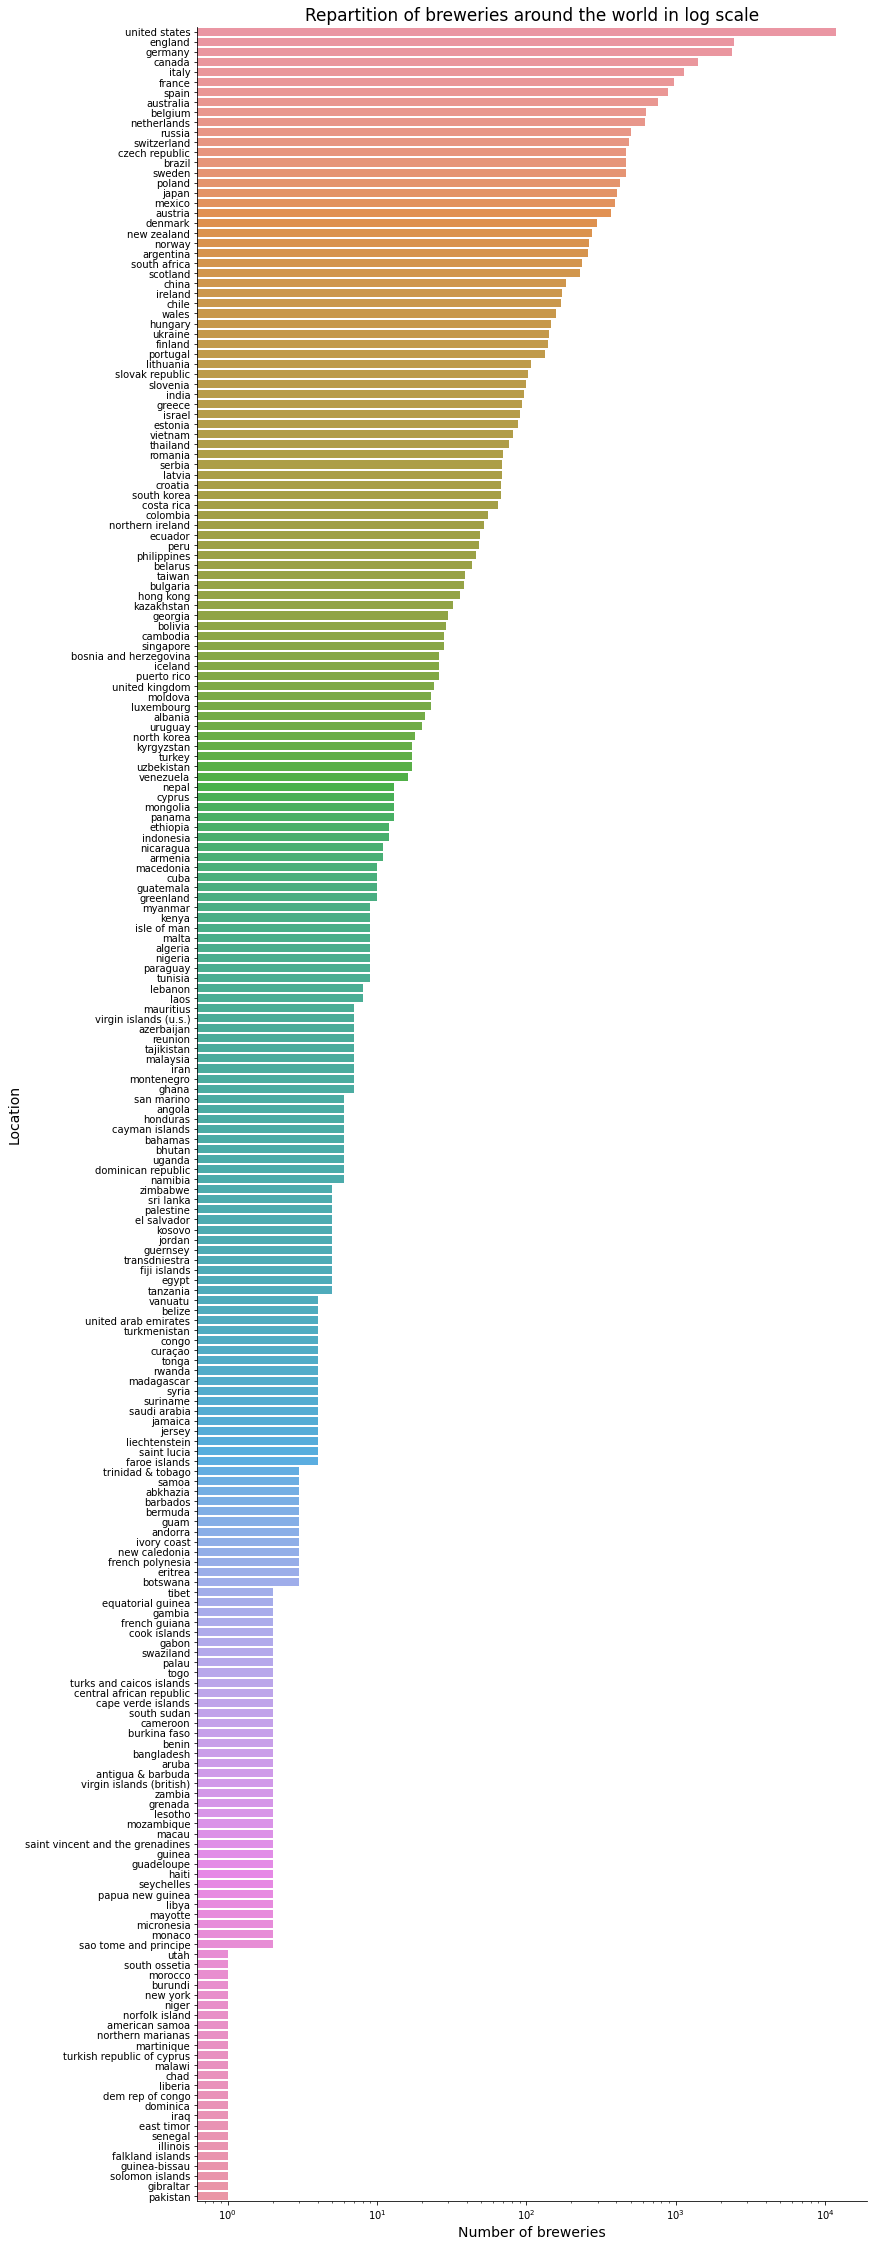

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(12,40))

new_breweries = breweries.groupby('location').agg('count').sort_values(by=['id'], ascending=False)

sns.barplot(data=new_breweries, x=new_breweries.id, y=new_breweries.index)
ax.set_title("Repartition of breweries around the world in log scale", fontsize = 17)
ax.set_xlabel("Number of breweries", fontsize = 14)
ax.set_ylabel("Location", fontsize = 14)
ax.set_xscale('log')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#### Interpretation

The log space version allows us to see the repartion of breweries in the other countries. In fact, real-world data is often skewed. For heavily skewed distributions, it’s better to define the bins in log space.

As we can see here, most of our breweries are from the United States with almost 7000 breweries. This can be explained by the fact that the population in the United States is much bigger than in the other countries. It could be interesting to see the repartition in the United State by states. In this way, it would be possible to match a person from America with a beer thanks to his state.

We don't have enough data for countries like Pakistant or Estonia. Those countries will be named breweries_few and will be removed from the dataframe breweries_big because it is not representative of the country.

In [30]:
# Brings together countries without enough breweries
tresh_nbr_breweries = 50

locations = []
for location in list(breweries.location.unique()):
    if len(breweries.loc[breweries.location == location]) < tresh_nbr_breweries:
        locations.append(location)

breweries_few = pd.DataFrame(columns = ['id', 'location', 'name', 'nbr_beers', 'state'])
breweries_big = breweries.copy()

for location in locations:
    breweries_few = pd.concat([breweries_few, breweries.loc[breweries.location == location]])
    breweries_big = breweries_big.drop(breweries_big[breweries_big.location == location].index)

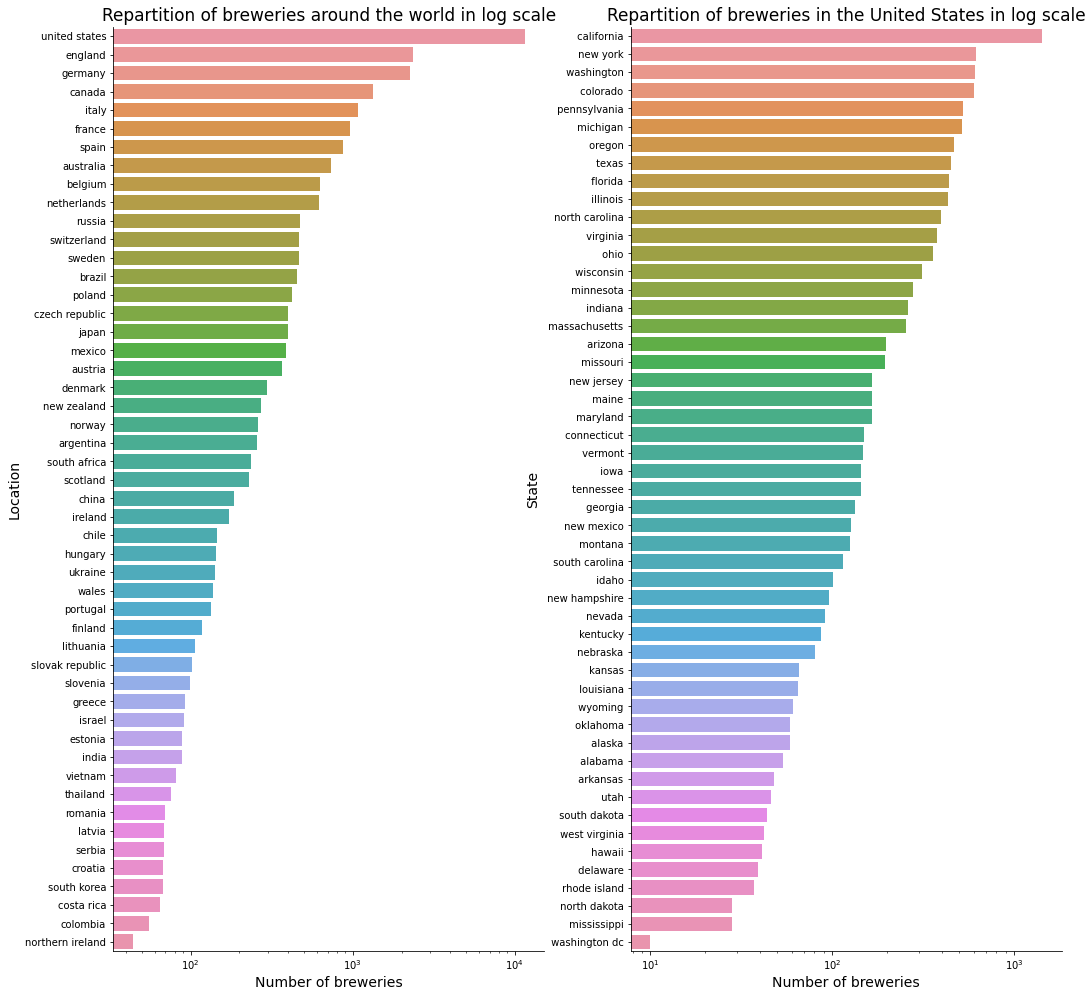

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(17, 17))

new_breweries_big = breweries_big.groupby('location').agg('count').sort_values(by=['id'], ascending=False)
breweries_US = breweries_big[breweries_big['location'] == 'united states']
breweries_US = breweries_US.drop(breweries_US[breweries_US.state == ' united states'].index)
new_breweries_US = breweries_US.groupby('state').agg('count').sort_values(by=['id'], ascending=False)

sns.barplot(data=new_breweries_big, x=new_breweries_big.id, y=new_breweries_big.index, ax=ax[0])
ax[0].set_title("Repartition of breweries around the world in log scale", fontsize = 17)
ax[0].set_xlabel("Number of breweries", fontsize = 14)
ax[0].set_ylabel("Location", fontsize = 14)
ax[0].set_xscale('log')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

sns.barplot(data=new_breweries_US, x=new_breweries_US.id, y=new_breweries_US.index, ax=ax[1])
ax[1].set_title("Repartition of breweries in the United States in log scale", fontsize = 17)
ax[1].set_xlabel("Number of breweries", fontsize = 14)
ax[1].set_ylabel("State", fontsize = 14)
ax[1].set_xscale('log')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

#### Interpretation

Finally, we had to remove some countries due to too little data. In addition, in order to match a beer with a person. For the case of the United State, it could be interesting to see the repartition of breweries for each state because of the number of data from the United State.

## How users are distributed across the world? 

Now that we have a general vision of breweries distribution arounf the world, we can compare it to the users distribution. This will be interesting in the following to see if beers production is corrolated with users productions. We will only visualize 'active' people, that is to say whose number of reviews is greater than a certain threshold.

### The dataset of users:

In [32]:
# BeerAdvocate
BA_users = pd.read_csv(BA_users_file)
BA_users = regularize_locations(BA_users)
print(f'Number of users = {len(BA_users)}')
BA_users.head(10)

Number of users = 153704


,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,state
0,7820,465,nmann08.184925,nmann08,1.199704e+09,united states,washington
1,2521,2504,stjamesgate.163714,StJamesGate,1.191838e+09,united states,new york
2,1797,1143,mdagnew.19527,mdagnew,1.116410e+09,northern ireland,NaN
3,31,31,helloloser12345.10867,helloloser12345,1.101380e+09,northern ireland,NaN
4,604,604,cypressbob.3708,cypressbob,1.069326e+09,northern ireland,NaN
5,2326,0,hellpop65.48993,Hellpop65,1.131966e+09,united states,kansas
6,3098,0,latarnik.52897,Latarnik,1.133521e+09,united states,new jersey
7,1866,23,rochefortchris.697017,RochefortChris,1.349172e+09,united states,north carolina
8,1131,188,okcnittany.144868,OKCNittany,1.182766e+09,united states,oklahoma
9,9987,16,jaydoc.265507,jaydoc,1.226488e+09,united states,kansas


In [33]:
# Ratebeer
RB_users = pd.read_csv(RB_users_file)
RB_users = regularize_locations(RB_users)
print(f'Number of users = {len(RB_users)}')
RB_users.head(10)

Number of users = 70174


,nbr_ratings,user_id,user_name,joined,location,state
0,1890,175852,Manslow,1.337508e+09,poland,NaN
1,89,442761,MAGICuenca91,1.484046e+09,spain,NaN
2,169,288889,Sibarh,1.384600e+09,poland,NaN
3,3371,250510,fombe89,1.363950e+09,spain,NaN
4,13043,122778,kevnic2008,1.296644e+09,germany,NaN
5,21024,227834,Beerhunter111,1.352718e+09,germany,NaN
6,8781,83106,Erzengel,1.224324e+09,germany,NaN
7,4051,37316,Lowenbrau,1.147860e+09,spain,NaN
8,435,75452,seynie,1.211278e+09,belgium,NaN
9,5795,17111,Cletus,1.100257e+09,united states,connecticut


In [34]:
# Join the two dataframe
users = pd.concat([BA_users, RB_users])
users = users.drop_duplicates(subset=['user_id'], keep='first')
print(f'Number of users = {len(users)}')
print(f'Number of different contries from breweries = {len(list(users.location.unique()))}')
users.head(1)

Number of users = 223824
Number of different contries from breweries = 202


,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,state
0,7820,465.0,nmann08.184925,nmann08,1.199704e+09,united states,washington


### Repartition of 'active' people

In [35]:
# Threshold
tresh_nbr_reviews = 100

In [36]:
active_users = users[users['nbr_reviews'] > tresh_nbr_reviews]

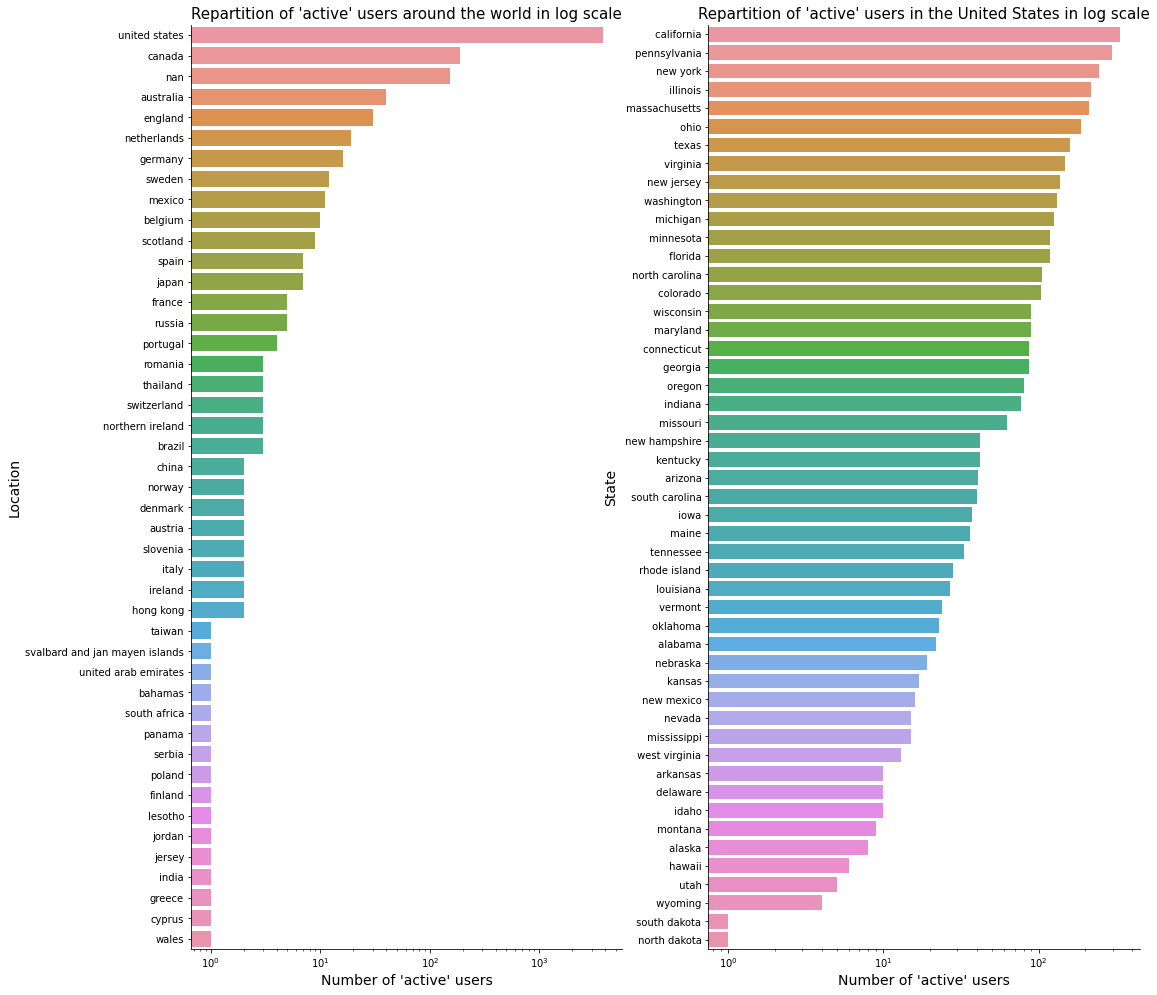

In [37]:
fig, ax = plt.subplots(1, 2, figsize=(17, 17))

new_active_users = active_users.groupby('location').agg('count').sort_values(by=['user_id'], ascending=False)
users_US = active_users[active_users['location'] == 'united states']
new_users_US = users_US.groupby('state').agg('count').sort_values(by=['user_id'], ascending=False)

sns.barplot(data=new_active_users, x=new_active_users.user_id, y=new_active_users.index, ax=ax[0])
ax[0].set_title("Repartition of 'active' users around the world in log scale", fontsize = 15)
ax[0].set_xlabel("Number of 'active' users", fontsize = 14)
ax[0].set_ylabel("Location", fontsize = 14)
ax[0].set_xscale('log')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

sns.barplot(data=new_users_US, x=new_users_US.user_id, y=new_users_US.index, ax=ax[1])
ax[1].set_title("Repartition of 'active' users in the United States in log scale", fontsize = 15)
ax[1].set_xlabel("Number of 'active' users", fontsize = 14)
ax[1].set_ylabel("State", fontsize = 14)
ax[1].set_xscale('log')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

#### Interpretation

Here the majority of active users are from the United States and Canada. This seems logic because of the number of the population. In this way it's important to compare it with the distribution of breweries to see if it is corrolated.

In addition, we can also see that an important part of users didn't precise their nationality. So, we can't use datas from those users to match a person with a beer.

### Correlation between repartion of 'active' users and breweries

In [38]:
breweries_loc_US = pd.DataFrame(columns = ['id', 'location', 'name', 'nbr_beers', 'state'])

users_US = active_users[active_users['location'] == 'united states']
new_users_US = users_US.groupby('state').agg('count').sort_values(by=['user_id'], ascending=False)

for state in list(new_users_US.index):
    breweries_loc_US = pd.concat([breweries_loc_US, breweries.loc[breweries.state == state]])

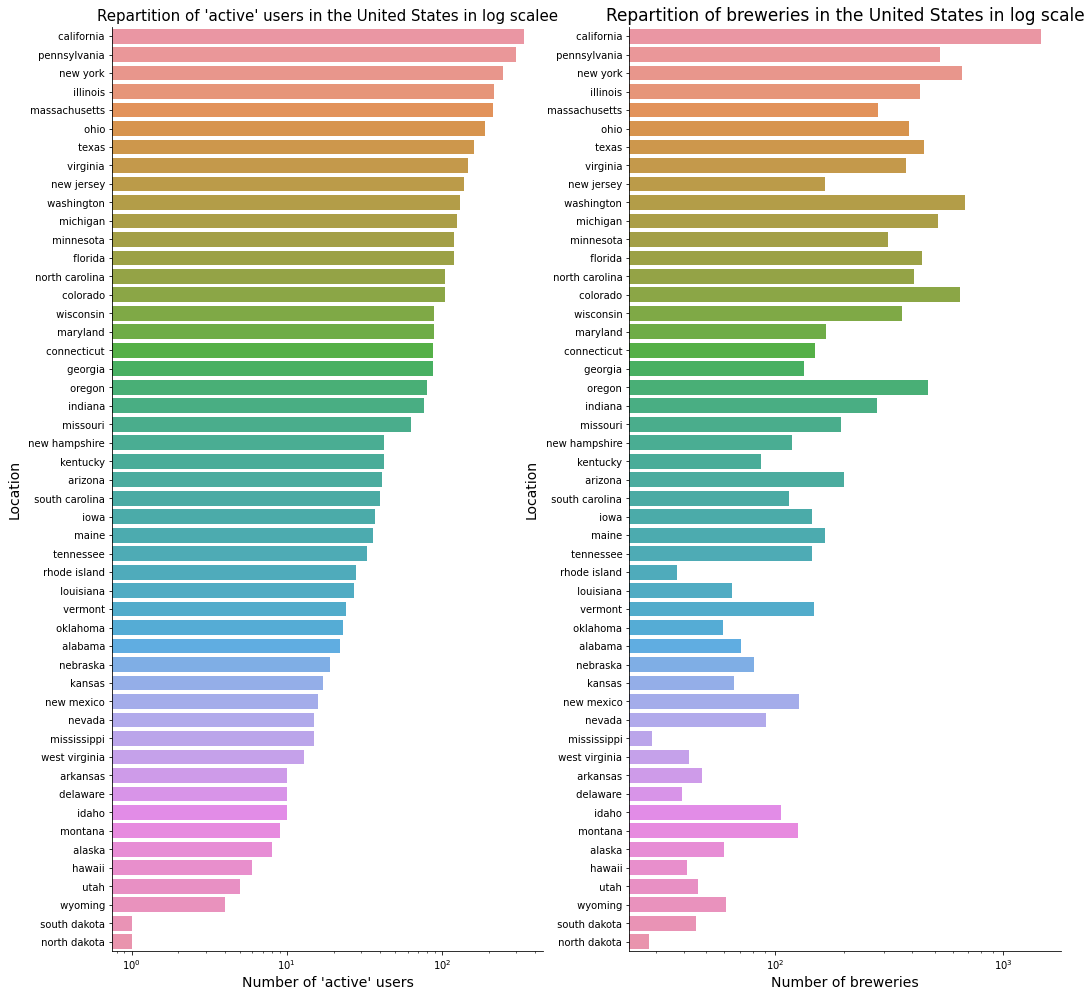

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(17, 17))

new_breweries_loc_US = breweries_loc_US.groupby('state').agg('count')
new_breweries_loc_US['user_id'] = new_users_US.user_id
new_breweries_loc_US = new_breweries_loc_US.sort_values(by=['user_id'], ascending=False)

sns.barplot(data=new_users_US, x=new_users_US.user_id, y=new_users_US.index, ax=ax[0])
ax[0].set_title("Repartition of 'active' users in the United States in log scalee", fontsize = 15)
ax[0].set_xlabel("Number of 'active' users", fontsize = 14)
ax[0].set_ylabel("Location", fontsize = 14)
ax[0].set_xscale('log')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

sns.barplot(data=new_breweries_loc_US, x=new_breweries_loc_US.id, y=new_breweries_loc_US.index, ax=ax[1])
ax[1].set_title("Repartition of breweries in the United States in log scale", fontsize = 17)
ax[1].set_xlabel("Number of breweries", fontsize = 14)
ax[1].set_ylabel("Location", fontsize = 14)
ax[1].set_xscale('log')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

In [40]:
active_users = active_users.drop(active_users[active_users.location == 'nan'].index, inplace=False)
breweries_loc = pd.DataFrame(columns = ['id', 'location', 'name', 'nbr_beers', 'state'])

new_active_users = active_users.groupby('location').agg('count').sort_values(by=['user_id'], ascending=False)

for loc in list(new_active_users.index):
    breweries_loc = pd.concat([breweries_loc, breweries.loc[breweries.location == loc]])

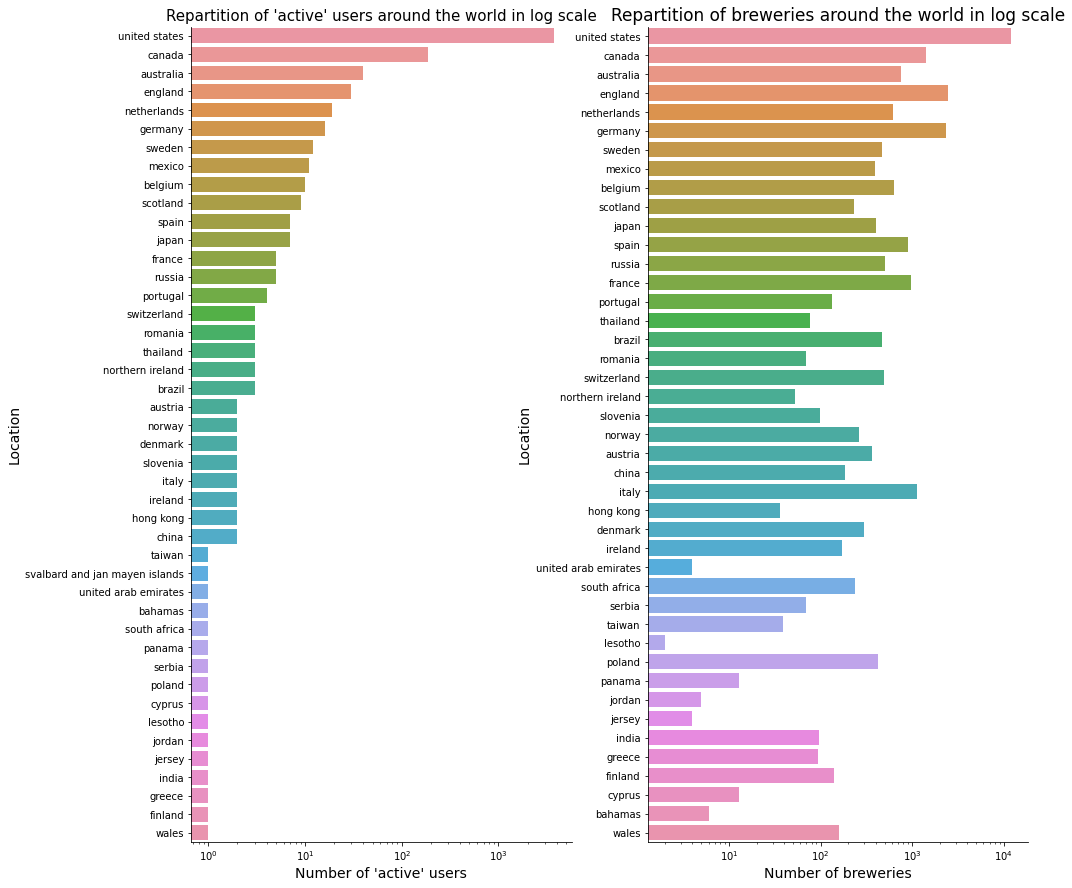

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))

new_breweries_loc = breweries_loc.groupby('location').agg('count')
new_breweries_loc['user_id'] = new_active_users.user_id
new_breweries_loc = new_breweries_loc.sort_values(by=['user_id'], ascending=False)

sns.barplot(data=new_active_users, x=new_active_users.user_id, y=new_active_users.index, ax=ax[0])
ax[0].set_title("Repartition of 'active' users around the world in log scale", fontsize = 15)
ax[0].set_xlabel("Number of 'active' users", fontsize = 14)
ax[0].set_ylabel("Location", fontsize = 14)
ax[0].set_xscale('log')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

sns.barplot(data=new_breweries_loc, x=new_breweries_loc.id, y=new_breweries_loc.index, ax=ax[1])
ax[1].set_title("Repartition of breweries around the world in log scale", fontsize = 17)
ax[1].set_xlabel("Number of breweries", fontsize = 14)
ax[1].set_ylabel("Location", fontsize = 14)
ax[1].set_xscale('log')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

#### Interpretation

It is easy to see here that in our dataset the United States proposes the most beers and has also the most active people. Then it follows with Canada, England and Australia. We can see that the more breweries a country offers, the more active a country is for the first ones. However after Taiwan we can observe that the people are not active when his country proposes more breweries. This can be explained by the fact that we don't have enough datas for those countries and so by population size.

Another factor may be that the country certainly offers a lot of breweries but little choice in the brewery.

### Repartition of beers

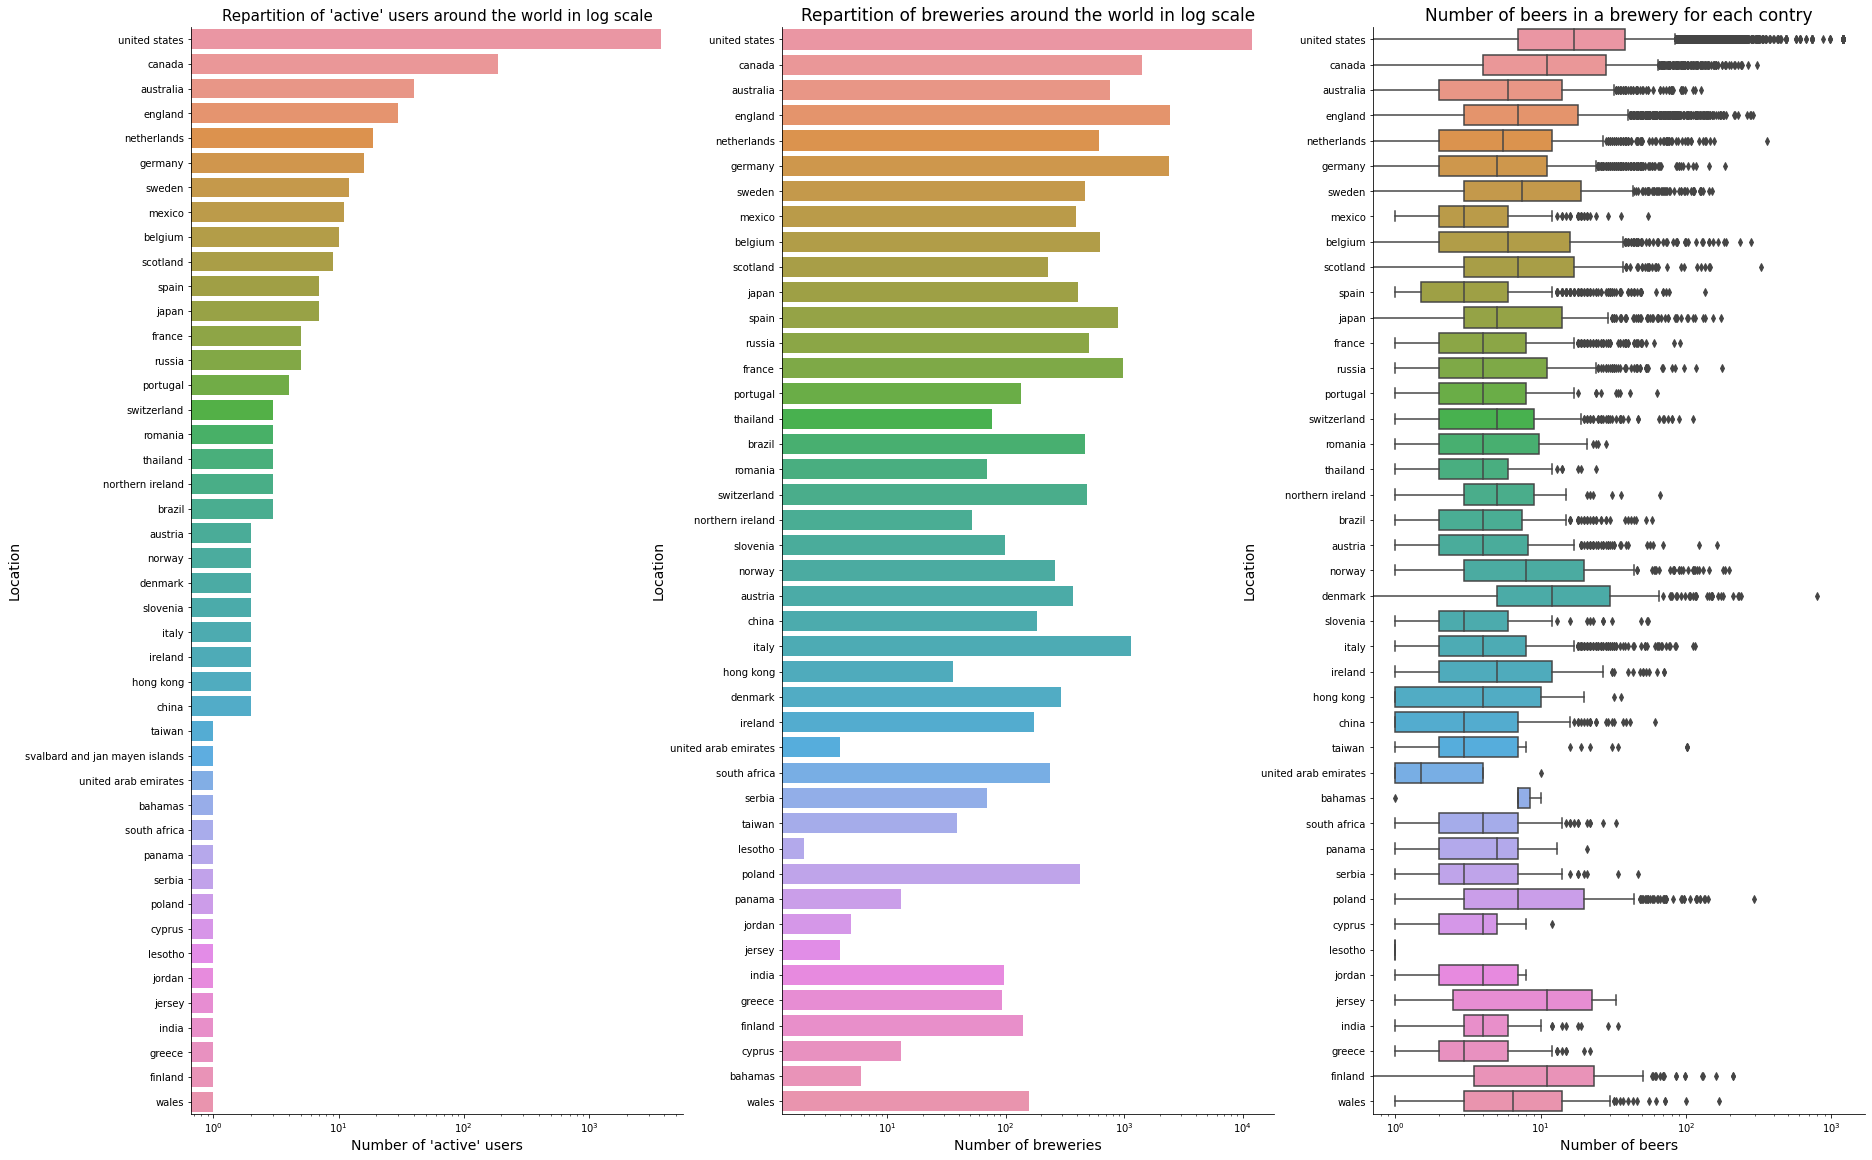

In [42]:
fig, ax = plt.subplots(1, 3, figsize=(30, 20))

new_breweries_loc = breweries_loc.groupby('location').agg('count')
new_breweries_loc['user_id'] = new_active_users.user_id
new_breweries_loc = new_breweries_loc.sort_values(by=['user_id'], ascending=False)

sns.barplot(data=new_active_users, x=new_active_users.user_id, y=new_active_users.index, ax=ax[0])
ax[0].set_title("Repartition of 'active' users around the world in log scale", fontsize = 15)
ax[0].set_xlabel("Number of 'active' users", fontsize = 14)
ax[0].set_ylabel("Location", fontsize = 14)
ax[0].set_xscale('log')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

sns.barplot(data=new_breweries_loc, x=new_breweries_loc.id, y=new_breweries_loc.index, ax=ax[1])
ax[1].set_title("Repartition of breweries around the world in log scale", fontsize = 17)
ax[1].set_xlabel("Number of breweries", fontsize = 14)
ax[1].set_ylabel("Location", fontsize = 14)
ax[1].set_xscale('log')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

sns.boxplot(x="nbr_beers", y="location", data=breweries_loc, ax=ax[2])
ax[2].set_title("Number of beers in a brewery for each contry", fontsize = 17)
ax[2].set_xlabel("Number of beers", fontsize = 14)
ax[2].set_ylabel("Location", fontsize = 14)
ax[2].set_xscale('log')
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)

#### Interpretation

We can observe that, in addition to be the countries which have the more breweries, the United States and Canada are countries with the most choice of beers in a brewery.

In general, except for certain cases like United Arab Emirates or Lesotho (because the number of beers proposes in a brewery is below average) and execpt for Finland, Poland, Denmark, Canada and the United States (because the number of beers proposes is above average), the number of beers proposes in each country seems to the same (between 1 beer and 30 beers).

We can also obersve than after Taiwan the number of active users are pretty small but the number of breweries is not also below average as for the choice of beers. So this unactive population in beers reviews maybe explain by the too few number of data for those country.

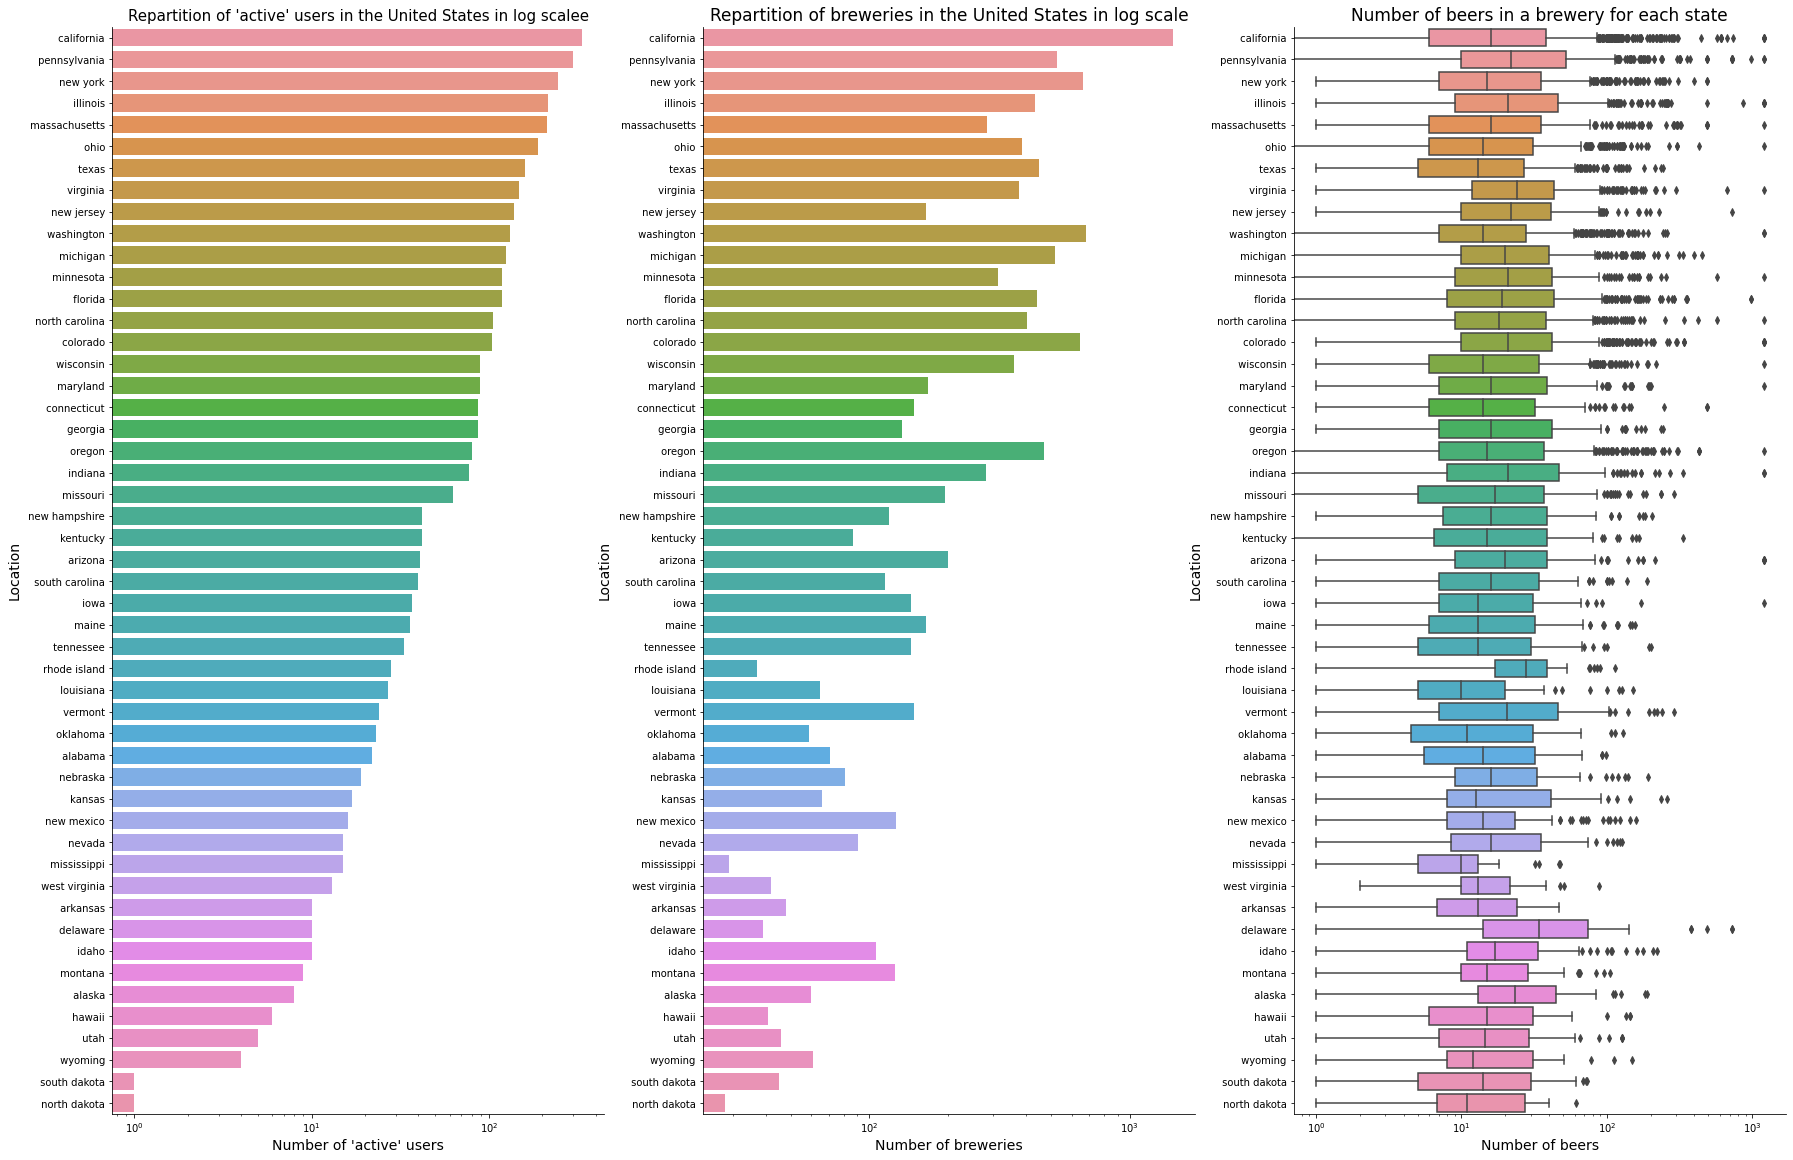

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(30, 20))

new_breweries_loc_US = breweries_loc_US.groupby('state').agg('count')
new_breweries_loc_US['user_id'] = new_users_US.user_id
new_breweries_loc_US = new_breweries_loc_US.sort_values(by=['user_id'], ascending=False)

sns.barplot(data=new_users_US, x=new_users_US.user_id, y=new_users_US.index, ax=ax[0])
ax[0].set_title("Repartition of 'active' users in the United States in log scalee", fontsize = 15)
ax[0].set_xlabel("Number of 'active' users", fontsize = 14)
ax[0].set_ylabel("Location", fontsize = 14)
ax[0].set_xscale('log')
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

sns.barplot(data=new_breweries_loc_US, x=new_breweries_loc_US.id, y=new_breweries_loc_US.index, ax=ax[1])
ax[1].set_title("Repartition of breweries in the United States in log scale", fontsize = 17)
ax[1].set_xlabel("Number of breweries", fontsize = 14)
ax[1].set_ylabel("Location", fontsize = 14)
ax[1].set_xscale('log')
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)

sns.boxplot(x="nbr_beers", y="state", data=breweries_loc_US, ax=ax[2])
ax[2].set_title("Number of beers in a brewery for each state", fontsize = 17)
ax[2].set_xlabel("Number of beers", fontsize = 14)
ax[2].set_ylabel("Location", fontsize = 14)
ax[2].set_xscale('log')
ax[2].spines['right'].set_visible(False)
ax[2].spines['top'].set_visible(False)

#### Interpretation

There are no main differences between the different states of America. In fact, the number of beers proposes in breweries in each states is approximatly the same. For all the breweries the number can vary from 1 beer to 100 beers.

## Conclusion

Finally, the logic would be that the more a country offers breweries, the more the people in the country will be 'active' but this is not always the case. This may be due to our data sources, as we do not have enough information on certain countries. Or by the choice of beers in each brehwery. In fact, maybe a country offers many breweries but not lot of beers. This means that people in this country don't drink many beers and so, are not as 'active' as expected. However we saw that the choice of beers in breweries seems to be constant for each country. But, in all cases, we saw that the activity of users are still, for the majority of countries, corrolated with the number of breweries.

To continue, another idea, which will be talked in the next part, would be that a person can be subject to biases. Indeed, a person will more easily appreciate the beers of his region or the beers offered in his region in addition to be more active.

In the following, we have to keep in mind that most of our data are from the United States.

# 2. Analysis of user preferences

## Relationship between user's country and beer origin

Let's have a look at possible indicators that may suggest correlations between the users country and the beers they review and prefer. 

In the following we will use the same datasets for users and breweries as the section before, we will just add the dataset of reviews.

### The dataset of reviews:

In [44]:
# BeerAdvocate
print(f'number of reviews from BeerAdvocate = {len(BA_reviews)}')
BA_reviews.head(10)

number of reviews from BeerAdvocate = 2589586


,beer_id,brewery_id,style,user_id,rating,beer_name,user_name,appearance,aroma,palate,taste,overall
0,142544,37262,Euro Pale Lager,nmann08.184925,2.88,Régab,nmann08,3.25,2.75,3.25,2.75,3.00
1,19590,10093,English Pale Ale,stjamesgate.163714,3.67,Barelegs Brew,StJamesGate,3.00,3.50,3.50,4.00,3.50
2,19590,10093,English Pale Ale,mdagnew.19527,3.73,Barelegs Brew,mdagnew,4.00,3.50,3.50,4.00,3.50
3,19590,10093,English Pale Ale,helloloser12345.10867,3.98,Barelegs Brew,helloloser12345,4.00,3.50,4.00,4.00,4.50
4,19590,10093,English Pale Ale,cypressbob.3708,4.00,Barelegs Brew,cypressbob,4.00,4.00,4.00,4.00,4.00
5,19827,10093,English Pale Ale,brewdude1982.691169,3.91,Legbiter,brewdude1982,4.25,4.50,3.25,3.75,3.75
6,19827,10093,English Pale Ale,agentmunky.409755,3.64,Legbiter,AgentMunky,4.00,3.75,3.50,3.50,3.75
7,19827,10093,English Pale Ale,ferrari29.320392,2.77,Legbiter,ferrari29,3.00,3.50,2.50,2.50,2.50
8,19827,10093,English Pale Ale,othershoe2.233642,3.68,Legbiter,OtherShoe2,4.00,3.50,4.00,3.50,4.00
9,19827,10093,English Pale Ale,brentk56.6284,2.84,Legbiter,brentk56,4.50,3.00,3.50,2.50,2.50


In [45]:
# RateBeer
print(f'number of reviews from RateBeer = {len(RB_reviews)}')
RB_reviews.head(10)

number of reviews from RateBeer = 7121988


,beer_id,brewery_id,style,user_id,rating,beer_name,user_name,appearance,aroma,palate,taste,overall
0,410549.0,3198.0,Pale Lager,175852.0,2.0,33 Export (Gabon),Manslow,2.0,4.0,2.0,4.0,8.0
1,105273.0,3198.0,Pale Lager,442761.0,1.9,Castel Beer (Gabon),MAGICuenca91,2.0,3.0,2.0,4.0,8.0
2,105273.0,3198.0,Pale Lager,288889.0,1.6,Castel Beer (Gabon),Sibarh,3.0,3.0,2.0,3.0,5.0
3,105273.0,3198.0,Pale Lager,250510.0,1.5,Castel Beer (Gabon),fombe89,4.0,3.0,1.0,2.0,5.0
4,105273.0,3198.0,Pale Lager,122778.0,1.9,Castel Beer (Gabon),kevnic2008,2.0,4.0,2.0,4.0,7.0
5,105273.0,3198.0,Pale Lager,227834.0,1.9,Castel Beer (Gabon),Beerhunter111,2.0,3.0,2.0,3.0,9.0
6,105273.0,3198.0,Pale Lager,83106.0,2.6,Castel Beer (Gabon),Erzengel,4.0,5.0,4.0,5.0,8.0
7,105273.0,3198.0,Pale Lager,175852.0,1.7,Castel Beer (Gabon),Manslow,2.0,4.0,2.0,3.0,6.0
8,105273.0,3198.0,Pale Lager,37316.0,2.0,Castel Beer (Gabon),Lowenbrau,3.0,5.0,2.0,3.0,7.0
9,105273.0,3198.0,Pale Lager,75452.0,1.8,Castel Beer (Gabon),seynie,2.0,3.0,3.0,4.0,6.0


In [46]:
# Join the two dataframe
reviews = pd.concat([BA_reviews, RB_reviews])
reviews = reviews.drop_duplicates(subset=['beer_id', 'user_id'], keep='first')
print(f'number of reviews = {len(reviews)}')
reviews.head(1)

number of reviews = 9711574


,beer_id,brewery_id,style,user_id,rating,beer_name,user_name,appearance,aroma,palate,taste,overall
0,142544.0,37262.0,Euro Pale Lager,nmann08.184925,2.88,Régab,nmann08,3.25,2.75,3.25,2.75,3.0


### The dataset of users:

In [47]:
# remove users which location is not specified
users = users.drop(users[users.location == 'nan'].index, inplace=False)
print(f'Number of users = {len(users)}')
users.head(1)

Number of users = 148989


,nbr_ratings,nbr_reviews,user_id,user_name,joined,location,state
0,7820,465.0,nmann08.184925,nmann08,1.199704e+09,united states,washington


In [48]:
users_country_list = list(users.location.unique())
print(f'Number of different contries form users = {len(users_country_list)}')

Number of different contries form users = 190


Storing the users' origin in a dictionary

In [49]:
users_contry_dict = dict(zip(users.user_id, users.location))

### The dataset of breweries:

In [50]:
print(f'Number of breweries = {len(breweries)}')
breweries.head(1)

Number of breweries = 32587


,id,location,name,nbr_beers,state
0,39912,kyrgyzstan,Abdysh-Ata (Абдыш Ата),5,NaN


In [51]:
print(f'Number of different contries from breweries = {len(list(breweries.location.unique()))}')

Number of different contries from breweries = 216


Storing the breweries' origin in a dictionary

In [52]:
breweries_contry_dict = dict(zip(breweries.id, breweries.location))

### Combining reviews, users and breweries:

For each review, we will check if the origin of the user (reviewer) is the same as the brewery (whose beer is being reviewed), marking it with a `1` if the contries match and `0` otherwise.

Merging users and breweries origin (filtering out cases where location in unknown):

In [53]:
def get_country(id, correspondance_dict):
    if id in correspondance_dict:
        return correspondance_dict[id]
    else:
        return np.nan

In [54]:
reviews.head(1)

,beer_id,brewery_id,style,user_id,rating,beer_name,user_name,appearance,aroma,palate,taste,overall
0,142544.0,37262.0,Euro Pale Lager,nmann08.184925,2.88,Régab,nmann08,3.25,2.75,3.25,2.75,3.0


In [55]:
reviews['user_country'] = reviews['user_id'].apply(
    lambda x: get_country(id=x, correspondance_dict=users_contry_dict)
)
reviews['brewery_country'] = reviews['brewery_id'].apply(
    lambda x: get_country(id=x, correspondance_dict=breweries_contry_dict)
)
reviews = reviews.dropna()

Creating a column to store if country is the same:

In [56]:
def is_contry_the_same(contry1, country2):
    if contry1==country2: 
        return 1
    else:
        return 0

In [57]:
reviews['is_same_country'] = reviews.apply(lambda row: is_contry_the_same(row.user_country, row.brewery_country), axis=1)

To check if the difference in origin between the user and beer is statistically significant across reviews, we will compute the 95% confidence intervals (using `scipy.stats`) of the generated column `is_same_country`:

In [58]:
def get_confidence_interval(data, title=None):
    interval = st.t.interval(alpha=0.95,
                df=len(data)-1,
                loc=np.mean(data), 
                scale=st.sem(data))
    print('--------------------------')
    if title:
        print(title)
    print()
    print(f'''Average = {np.mean(data)}
Confidence interval = {interval}''')
    print('--------------------------')
    return interval

In [59]:
interval = get_confidence_interval(list(reviews.is_same_country), "Comparison between user and beer origin from all reviews:")

--------------------------
Comparison between user and beer origin from all reviews:

Average = 0.5123105196464498
Confidence interval = (0.5119760705451146, 0.512644968747785)
--------------------------


#### Interpretation

This result indicates that, for all reviews, the country of the user (reviewer) tend to be the same as the beer being reviewed with more than 0.5 as an average. In this way, the user will have more probability to make reviews on beers which origin is his origin. In fact, we have to take into account that there are many more countries which are not this person's country so the probability of any given country being one's (unique) contry of origin should be very low.

What we want to investigate further here is the user's *preference* as a function of country, which can be hidden inside the gross number of reviews. 

### Metrics to capture user's preference

Some initial ideas to capture the users preferences are related to analyzing what are the styles and countries of origin of each person's most frequent reviews, as well as the individual's best rated reviews. 

This type of analysis can be done with the following function, which we intend to develop and build upon in the third phase of the project:

In [60]:
def get_user_preferences_df(reviews, number_of_reviews_threshold=10):
    grouped = reviews.groupby('user_id')
    data = []
    for user_id, group in grouped:
        if len(group) >= number_of_reviews_threshold:
            row_dict = {}
            row_dict['user_id'] = user_id
            row_dict['user_country'] = users_contry_dict[user_id]

            most_frequent_style = group['style'].value_counts().idxmax()
            row_dict['most_frequent_style'] = most_frequent_style

            most_frequent_country = group['brewery_country'].value_counts().idxmax()
            row_dict['most_frequent_country'] = most_frequent_country

            highest_rated_index = group['rating'].idxmax()
            highest_rated_beer = reviews.loc[highest_rated_index]
            highest_rated_beer = highest_rated_beer[~highest_rated_beer.index.duplicated(keep="first")].squeeze()
            row_dict['highest_rating'] = highest_rated_beer.rating
            row_dict['highest_rated_origin'] = highest_rated_beer.brewery_country

            row_dict['is_country_same_as_highest_rated'] = 1 if highest_rated_beer.brewery_country == users_contry_dict[user_id] else 0
            row_dict['is_country_same_as_most_frequent'] = 1 if most_frequent_country == users_contry_dict[user_id] else 0

            avg_rating_per_style = group.groupby(['style'])['rating'].mean().to_dict()
            row_dict['highest_rated_style'] = max(avg_rating_per_style, key=avg_rating_per_style.get)
            row_dict['lowest_rated_style'] = min(avg_rating_per_style, key=avg_rating_per_style.get)

            # row_dict['favorite_beers_avg_rating'] = group[group['style'] == most_frequent_style]['rating'].mean()
            # row_dict['other_beers_avg_rating'] = group[group['style'] != most_frequent_style]['rating'].mean()

            data.append(row_dict)
    return pd.DataFrame(data)

In order to have a solid grasp of each individuals preferences, we decided to consider individuals with at the number of least $n$ different ratings. Although this can reduce the number of instances in our analysis, it makes the estimation of the user's preferences more robust.

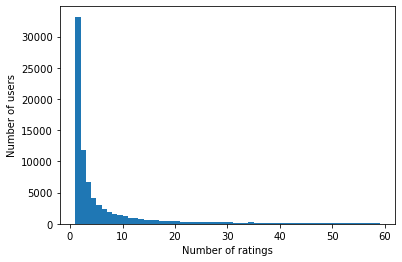

In [61]:
fig = plt.figure().set_size_inches(6,4)
number_of_reviews = reviews.value_counts('user_id').values
bins = np.arange(1, 60, 1)
plt.ylabel('Number of users')
plt.xlabel('Number of ratings')
plt.hist(number_of_reviews, bins=bins)
plt.show()

In [62]:
number_of_reviews

array([43250, 39239, 32658, ...,     1,     1,     1], dtype=int64)

Here, we would like compare how the most reviewed country for each individual and the origin of her/his highest rated beer relates to its own country. For this reason, we compute the average values and confidence intervals for both the `is_country_same_as_highest_rated` and `is_country_same_as_most_frequent` fields generated below.

In [63]:
user_prefs_df = get_user_preferences_df(reviews)

In [64]:
user_prefs_df.head(1)

,user_id,user_country,most_frequent_style,most_frequent_country,highest_rating,highest_rated_origin,is_country_same_as_highest_rated,is_country_same_as_most_frequent,highest_rated_style,lowest_rated_style
0,2.0,united states,Premium Bitter/ESB,united states,4.9,united states,1,1,Dry Stout,Witbier


In [65]:
interval = get_confidence_interval(list(user_prefs_df.is_country_same_as_most_frequent), "Comparison between user and beer origin for most frequent beer country:")

--------------------------
Comparison between user and beer origin for most frequent beer country:

Average = 0.82211749670514
Confidence interval = (0.817380502754738, 0.8268544906555421)
--------------------------


In [66]:
interval = get_confidence_interval(list(user_prefs_df.is_country_same_as_highest_rated), "Comparison between user and beer origin for highest rated review:")

--------------------------
Comparison between user and beer origin for highest rated review:

Average = 0.5623227764687088
Confidence interval = (0.5561775332115798, 0.5684680197258377)
--------------------------


#### Interpretation

As it can be observed in this preliminary analysis, the average value of the most frequent beer country is higher than the country of the highest reviews for each individual. This can point to a be subtle trend for the users reviewing on average more beers from their own country, but not necessarly having these beers as their favorite (they can be from a different country).

Improved versions of these type of analysis are planned to be made in the third part of the project, accounting for all ratings from both beer reviews websites. Among other things, further care will be taken to analysis cases where 
inherant imbalances in the dataset between beers and reviews may affect the final results and conclusions 

### Illustrative analysis

Beyond computing metrics, we plan to make visualizations of the prefered beers across styles and countries around the world, in a way that may support our insights from the data generated. Illustrative analysis relate the user's country of origin, brewery's country of origin and beer style as follows:

In [67]:
def get_beer_style_matrix(df, category, n_most_frequent=15):
    new_df = df[['user_country', category]].copy()
    most_frequent_countries = list(new_df['user_country'].value_counts()[:n_most_frequent].keys())
    most_frequent_styles = list(new_df[category].value_counts()[:n_most_frequent].keys())

    new_df.user_country = new_df.user_country.astype("category")
    new_df.user_country = new_df.user_country.cat.set_categories(most_frequent_countries)
    new_df.sort_values(['user_country'])
    
    new_df[category] = new_df[category].astype("category")
    new_df[category] = new_df[category].cat.set_categories(most_frequent_styles)
    new_df.sort_values([category])

    new_df = new_df[new_df['user_country'].isin(most_frequent_countries)]
    new_df = new_df[new_df[category].isin(most_frequent_styles)]
    new_df['count'] = 1
    new_df = pd.pivot_table(new_df, values=['count'], index=['user_country'],
                        columns=[category], aggfunc=np.sum, fill_value=0)
    return new_df['count'], n_most_frequent

Text(0.5, 1.0, "Normalize origin of beers the most reviewed across countries:\nuser's country $\\times$ its most frequent style of beer\n(only shown for top 15 countries and styles)")

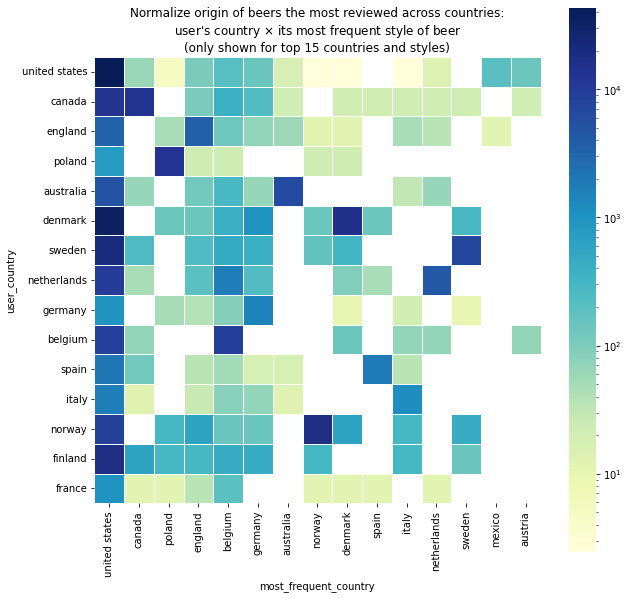

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

most_frequent_df, n_most_frequent = get_beer_style_matrix(
    df=user_prefs_df,
    category='most_frequent_country'
)
population=pd.DataFrame({'location':[location for location in most_frequent_df.index],
                  'population': [population_dict[location] if location in population_dict else 0 for location in most_frequent_df.index]})
population.population = [pop/sum(list(population.population)) for pop in list(population.population)]
population = population.set_index('location')

new_most_frequent_df = most_frequent_df.head(0)
for index, row in most_frequent_df.iterrows():
    new_most_frequent_df = pd.concat([new_most_frequent_df, most_frequent_df.loc[most_frequent_df.index == index, :]/float(population.loc[population.index == index, 'population'])])

new_most_frequent_df = new_most_frequent_df.dropna()
sns.heatmap(new_most_frequent_df, cmap="YlGnBu", linewidths=.6, square=True, norm=LogNorm())

plt.title(f'''Normalize origin of beers the most reviewed across countries:
user's country $\\times$ its most frequent style of beer
(only shown for top {n_most_frequent} countries and styles)''')

#### Interpretation

Here we plot only for countries which made the most reviewed.

We can notice that for majority of countries, the beers on which the users made the most reviews correspond to beers from breweries initially in the United States. Indeed, this can be explained by the analysis of the first part where we observed that most of our data came from the United States, in particular the number of breweries. Thus it is more likely that the user notes beers from breweries in the United States.

However, we can also notice that after removing the case of the United States, the most commented beers for the majority of countries come from the breweries from the same countries. This seems logical because individuals will more easily reviewd beers that come from their home. So, here we can observe that the individuals' reviews of beers are affected by possible confounding factors, xhich is, whether there are reviewers in locations with limited access of various beer types/origins, which gives a possibly present a "distorted" view on the individual's preferences.

However, now, it could be interesting to have a visualisation on the origin of the highest rated beers for each country. In fact, maybe people review more beers from their country but those beers are not their favorites.

Text(0.5, 1.0, "Normalize origin of beers prefered across countries:\nuser's country $\\times$ its most frequent style of beer\n(only shown for top 15 countries and styles)")

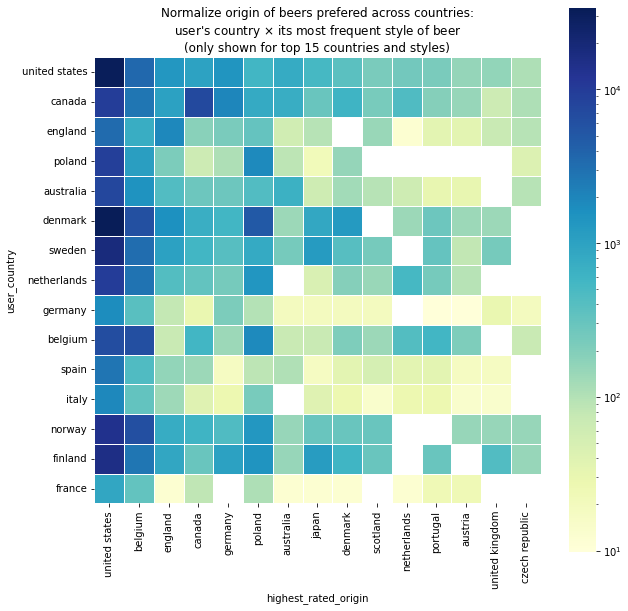

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

most_frequent_df, n_most_frequent = get_beer_style_matrix(
    df=user_prefs_df,
    category='highest_rated_origin'
)
population=pd.DataFrame({'location':[location for location in most_frequent_df.index],
                  'population': [population_dict[location] if location in population_dict else 0 for location in most_frequent_df.index]})
population.population = [pop/sum(list(population.population)) for pop in list(population.population)]
population = population.set_index('location')

new_most_frequent_df = most_frequent_df.head(0)
for index, row in most_frequent_df.iterrows():
    new_most_frequent_df = pd.concat([new_most_frequent_df, most_frequent_df.loc[most_frequent_df.index == index, :]/float(population.loc[population.index == index, 'population'])])

new_most_frequent_df = new_most_frequent_df.dropna()
sns.heatmap(new_most_frequent_df, cmap="YlGnBu", linewidths=.6, square=True, norm=LogNorm())

plt.title(f'''Normalize origin of beers prefered across countries:
user's country $\\times$ its most frequent style of beer
(only shown for top {n_most_frequent} countries and styles)''')

#### Interpretation

Thus, here it is visible that the origins of the preferred beers are the United States, which can be explained again by the number of data, and Belgium. But here there is not necessarily more data on Belgium as seen in part 1. The beers of this country are therefore the globally the prefered beers.

In this way, users review more beers from their own country, but not necessarly having these beers as their favorite

However, we can still observe even if it is less visible that individuals have a tendency to prefer beers from their country because squares matching the same countries on the rows and on the columns are more blue than the ones near them. Maybe, as we saw juste before, this can be explained by confounders like some people only have access to beers from their origin.

Nevertheless, this allustrative analysis shows that people tend to prefer beers of their origin. After that, we can do a visualization to see for each country which style of beer, it population did the most reviews and prefered.

Text(0.5, 1.0, "Normalize style of beers the most reviewed across countries:\nuser's country $\\times$ its most frequent style of beer\n(only shown for top 15 countries and styles)")

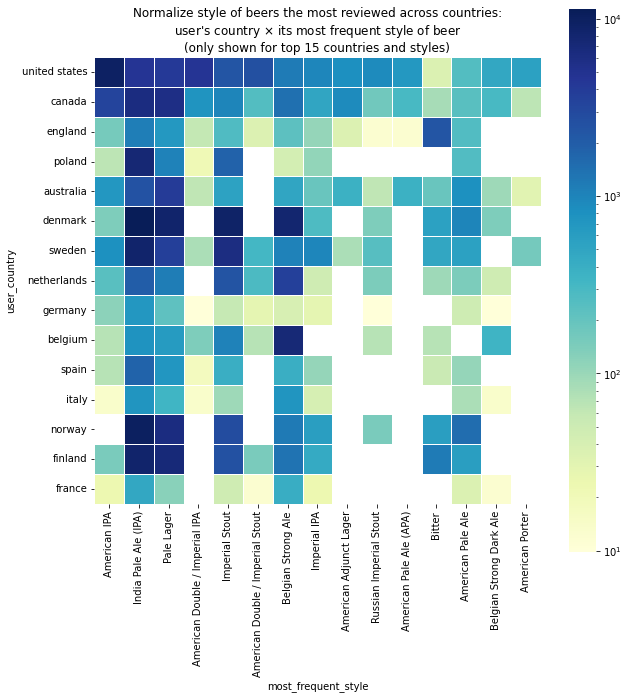

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

most_frequent_df, n_most_frequent = get_beer_style_matrix(
    df=user_prefs_df,
    category='most_frequent_style'
)
population=pd.DataFrame({'location':[location for location in most_frequent_df.index],
                  'population': [population_dict[location] if location in population_dict else 0 for location in most_frequent_df.index]})
population.population = [pop/sum(list(population.population)) for pop in list(population.population)]
population = population.set_index('location')

new_most_frequent_df = most_frequent_df.head(0)
for index, row in most_frequent_df.iterrows():
    new_most_frequent_df = pd.concat([new_most_frequent_df, most_frequent_df.loc[most_frequent_df.index == index, :]/float(population.loc[population.index == index, 'population'])])

new_most_frequent_df = new_most_frequent_df.dropna()
sns.heatmap(new_most_frequent_df, cmap="YlGnBu", linewidths=.6, square=True, norm=LogNorm())

plt.title(f'''Normalize style of beers the most reviewed across countries:
user's country $\\times$ its most frequent style of beer
(only shown for top {n_most_frequent} countries and styles)''')

Text(0.5, 1.0, "Normalize style of beers prefered across countries:\nuser's country $\\times$ its most frequent style of beer\n(only shown for top 15 countries and styles)")

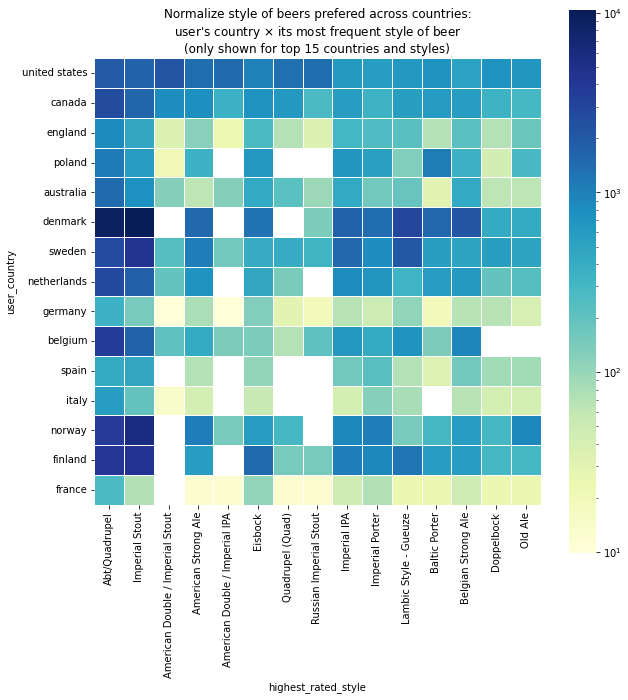

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

most_frequent_df, n_most_frequent = get_beer_style_matrix(
    df=user_prefs_df,
    category='highest_rated_style'
)
population=pd.DataFrame({'location':[location for location in most_frequent_df.index],
                  'population': [population_dict[location] if location in population_dict else 0 for location in most_frequent_df.index]})
population.population = [pop/sum(list(population.population)) for pop in list(population.population)]
population = population.set_index('location')

new_most_frequent_df = most_frequent_df.head(0)
for index, row in most_frequent_df.iterrows():
    new_most_frequent_df = pd.concat([new_most_frequent_df, most_frequent_df.loc[most_frequent_df.index == index, :]/float(population.loc[population.index == index, 'population'])])

new_most_frequent_df = new_most_frequent_df.dropna()
sns.heatmap(new_most_frequent_df, cmap="YlGnBu", linewidths=.6, square=True, norm=LogNorm())

plt.title(f'''Normalize style of beers prefered across countries:
user's country $\\times$ its most frequent style of beer
(only shown for top {n_most_frequent} countries and styles)''')

#### Interpretation

Thanks to those plots, we have a global view of beer preferences. Indeed, we can observe for each country a style of beer which emerges compared to the others.

We can also notice that the IPA beers are the most commented on but not the favorite beers. This may be due to a fashion for IPA beers which appeared, so many people started talking about it without this style being appreciated.

In any case with the last plot, we can, for each country, know which style of beer the country prefers (Abt/Quadrupel for Canada, Netherlands or Belgium ; Imperial Stout for Norway, Denmark, Sweden or Australia, ; Baltic Porter for Poland...).

## Analysis of the textual reviews: sentiment estimation 

The datasets of reviews from both platforms (BeerAdvocate and RateBeer) provide a textual description of the beer given by the user as rating it. In similar light of what has been done in previous exercises and homeworks, we would like to perform a sentiment analysis of the textual data provided in the reviews, and compared it with the ratings itself. This enable us to investigate how much the user's final rating is in accordance/correlated to her/his testimony, and also estimate the applicability/effectiveness of the straighfoward approach of stablish a sentiment score based on the number of positive and negative words the user employs in its review.

In this analysis, we narrow the reviews considering only the ones coming from users in the United States. As previously seen, this is the country with the most active users and widest variety of (local) beers. Furthermore, the language of the reviews being english facilitates the process of sentiment analysis employed here.

In order to parse the textual data of all relevant reviews, we employ a function constructure in the python code of the file `get_sentiment_count.py` (this is done outside this jupyter notebook for technical reasons). There we loop through all the reviews and filter for the ones coming from users from the U.S. only. The textual data of each review is then parsed, and passed to functions that count the number of positive and negative words. Aditionally, we also get the information of whether the beer being reviewed originally comes from the same country as the user, as it will be further discussed. The important snippets of these methods are also provided below:

In [72]:
positive_words = set(requests.get('https://ptrckprry.com/course/ssd/data/positive-words.txt').text.split('\n')[35:])
negative_words = set(requests.get('https://ptrckprry.com/course/ssd/data/negative-words.txt').text.split('\n')[35:])
punctuation_toberemoved = string.punctuation.translate({ord(i) : None for i in '+-'})

def sentiment_count(sentence, type):
    words = list(sentence.lower().translate(str.maketrans('', '', punctuation_toberemoved)).split(' '))
    if type == 'positive':
        return len([w for w in words if w in positive_words])
    elif type == 'negative':
        return len([w for w in words if w in negative_words])

def get_rating_text_with_list_of_dicts(file_path:str, user_list:set, breweries_list:set):
    rating = None
    text = ''
    user_in_list = False
    same_country = 0
    reviews_list = []
    with open(file_path, 'r', encoding="utf8") as r_file:
        for line in r_file:
            if line.split(':')[0] == 'user_id':
                if line.split(':')[1].strip() in user_list:
                    user_in_list = True
                    continue
            if line.split(':')[0] == 'brewery_id':
                if line.split(':')[1].strip() in breweries_list:
                    same_country = 1
                    continue
            if line.split(':')[0] == 'rating':
                rating = line.split(':')[1].strip()
                continue
            elif line.split(':')[0] == 'text':
                text = line.split(':')[1].strip()
                continue
            elif line == '\n':
                if rating and text and user_in_list:
                    d = {
                        'positive': sentiment_count(sentence=text, type='positive'),
                        'negative': sentiment_count(sentence=text, type='negative'),
                        'rating':rating,
                        'same_country': same_country
                    }
                    reviews_list.append(d)
                rating = None
                text = ''
                user_in_list = False
                same_country = 0
    return reviews_list

The result is then dumped into zipped json files located in `./datasets/sentiment_analysis` that can be directly loaded into a DataFrame:

In [73]:
BA_sentiment_count_df = pd.read_json('./datasets/sentiment_analysis/us_sentiment_count_BeerAdvocate.json.zip')
RB_sentiment_count_df = pd.read_json('./datasets/sentiment_analysis/us_sentiment_count_RateBeer.json.zip')

The number of analysed textual reviews is:

In [74]:
print(f'BeerAdvocate: {len(BA_sentiment_count_df):,}')
print(f'RateBeer: {len(RB_sentiment_count_df):,}')
sa_df = pd.concat([BA_sentiment_count_df, RB_sentiment_count_df])
print(f'Total number of reviews: {len(sa_df):,}')

BeerAdvocate: 2,241,309
RateBeer: 3,107,147
Total number of reviews: 5,348,456


In [75]:
sa_df.head(2)

,positive,negative,rating,same_country
0,5,9,2.88,0
1,2,2,3.67,0


### How strong is the final rating correlated with the positive/negative wordcount?

Let's do relative statistical t-tests to verify that:

In [76]:
def run_ttest(df, word_type):
    statistic, pvalue = ttest_rel(
        a=df[word_type],
        b=df.rating
    )
    print('--------------------\n')
    print(f'type: {word_type} words')
    print(f't-statistic: {statistic}')
    print(f'p-value = {pvalue}')
    print()

In [77]:
for word_type in ['positive', 'negative']:
    run_ttest(df=sa_df, word_type=word_type)

--------------------

type: positive words
t-statistic: 798.5851206010806
p-value = 0.0

--------------------

type: negative words
t-statistic: -253.65841213607965
p-value = 0.0



#### Interpretation

Here we can see a very strong correlation between the use of both positive words (positive correlation) and negative words (negative correlations) on the final numeric rating given in each review. This is given by the high magnitude (both positive and negative) given by the computed t-statistic of both tests, accompanied by a p-value which is lower than 0.0005.

In order to estimate the average mutual-influence on the words usage and final numeric rating, we can use the tools provided by linear regression:

### Analysing the relashionship between words usage and numerical rating with linear regression

In [78]:
mod = smf.ols(formula='rating ~ positive + negative', data=sa_df)

np.random.seed(2)
res = mod.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                 2.128e+05
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        13:46:50   Log-Likelihood:            -5.3571e+06
No. Observations:             5348456   AIC:                         1.071e+07
Df Residuals:                 5348453   BIC:                         1.071e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.4689      0.000   8594.200      0.0

#### Interpretation

Here, we can see that the beer rating scores have a average baseline of 3.47 (out of five), and that the use of each positive word is correlated with the increase of an average of 0.05 points in the final score. The opposite happens for negative words, where its use is associated with a decrease of 0.05 score points (per word). In all cases, we can observe p-values being smaller than 0.0005

So, we can see that this simple methodology of sentiment analysis on the textual data represents a robust way of quantifying the degree of satisfaction/appreatiation of the user with the beer being reviewed. In this way, we can also analyse the overall sentiment of the textual data of users when rating beers from their own country (U.S.) and beers from other countries.

As mentioned before, in the parsing of the textual data from the reviews file, we have checked whether the beer being reviewed is from the same country as the user, including this information in the column `same_country`, which can store the value of either `1` (beer and user are from the same country) or `0` (not from the same country).

In [79]:
count_dict = dict(sa_df.same_country.value_counts())
for var, t in zip(count_dict.keys(), ['', 'not ']):
    print(f'User and beer {t}from the same country: {count_dict[var]:,} reviews ({(count_dict[var]*100)/len(sa_df):.2f} %)')

User and beer from the same country: 4,232,029 reviews (79.13 %)
User and beer not from the same country: 1,116,427 reviews (20.87 %)


We can therefore include this information in our linear regression analysis:

In [80]:
regressions = [
    'positive ~ same_country',
    'negative ~ same_country',
    'rating ~ positive + negative + same_country'
]
labels = ['A', 'B', 'C']

def run_linregress_exp(regression:str, label:str):
    print(f'************************************************************************')
    print(f'                             REGRESSION {label}')
    print(f'************************************************************************\n')
    mod = smf.ols(formula=regression, data=sa_df)

    np.random.seed(2)
    res = mod.fit()

    print(res.summary())
    print('\n\n')

for r, l in zip(regressions, labels):
    run_linregress_exp(r, l)

************************************************************************
                             REGRESSION A
************************************************************************

                            OLS Regression Results                            
Dep. Variable:               positive   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     6.003
Date:                Thu, 22 Dec 2022   Prob (F-statistic):             0.0143
Time:                        13:46:52   Log-Likelihood:            -1.6632e+07
No. Observations:             5348456   AIC:                         3.326e+07
Df Residuals:                 5348454   BIC:                         3.326e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   co

#### Interpretation

Interpreting the different regressions individually, we can see that:
- Regression A: the difference in use of positive words for beers that come from the same country or different country as the user is minor: they differ in 0.01 words in average.
- Regression B: the difference in use of negative words is one order of magnitude larger in the previous case: beers from the same country as the user receive an average of 0.2 less negative words than the ones from different countries.
- Regression C: Analysing the effect of these variables on the final rating, the observations on the use of words maintains the same as seen before: each positive (negative) word is related to an increase (decrease) of 0.05 score points on avarage. But stronger than that is the effect of the beer origin: being from the same country of the user is associated with a average increase in 0.11 score points in the final rating. 

So, from these notes, we can infer that beers coming from outside of the United States receive on average 0.2 more negative words in their textual description and a numerical rating on average 0.11 score points lower. 

But, one question that still may arise is *"what if the beer from the U.S. is simply better than the average, and U.S. users are not biased at all?"*.

In order to try to disentagle these observations, let's check the average rating of the beer from the U.S. and the beers from other countries:

In [81]:
df_breweries = pd.concat([
    pd.read_csv('./datasets/BeerAdvocate/breweries.csv'),
    pd.read_csv('./datasets/RateBeer/breweries.csv')
])
df_breweries = regularize_locations(df_breweries)
df_breweries['from_us'] = df_breweries['location'].apply(lambda x: x == 'united states')
brewery_country = dict(zip(df_breweries.id, df_breweries.location))

In [82]:
df_beers = pd.concat([
    pd.read_csv('./datasets/BeerAdvocate/beers.csv'),
    pd.read_csv('./datasets/RateBeer/beers.csv')
])
df_beers['location'] = df_beers['brewery_id'].apply(lambda x: brewery_country[x])
df_beers.head(1)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings,overall_score,style_score,location
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0.0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN,NaN,NaN,kyrgyzstan


In [83]:
df_beers['is_from_us'] = df_beers['location'].apply(lambda x: x == 'united states')
df_beers.is_from_us.value_counts()

True     369127
False    353777
Name: is_from_us, dtype: int64

In [84]:
print('The average rating of beers from the U.S. and outside the U.S.:')
df_beers.groupby(['is_from_us'])['avg'].mean()

The average rating of beers from the U.S. and outside the U.S.:


is_from_us
False    3.234581
True     3.354537
Name: avg, dtype: float64

#### Interpretation

Here, we can see that the average rating of beers from the United States is indeed 0.12 score points higher than the group of non-american beers (3.35 against 3.23). However, from the results of previous linear regressions with the ratings from users, we see that beers from the U.S. reviewed by americans receive even higher scores than the global average (3.38 + 0.11 = 3.49 score points).  

# 3. Analysis of beer attributes

The reviews dataset from BeerAdvocate and RateBeer provide ratings for different beer caracteristics, let's have a look at them:

In [85]:
reviews.head(1)
print(f'Number of reviews : {len(reviews)}')

Number of reviews : 8580507


By the nature of the dataframe reviews being a concat of two other dataframe from different websites, there is a high probability of having the same beer ID for two different beer. This problem can be adressed as follow :

In [86]:
len(reviews.beer_id.unique())

429791

In [87]:
reviews['beer_id'] = reviews.groupby('beer_name')['beer_id'].transform('min')

In [88]:
len(reviews.beer_id.unique())

415911

In [89]:
beer_attributes = ['appearance', 'aroma', 'palate', 'taste']
for att in beer_attributes + ['overall', 'rating']:
    reviews[att] = reviews[att].astype(float)
reviews = reviews.dropna()
beer_attributes_df = reviews[beer_attributes]
beer_attributes_df.describe()

,appearance,aroma,palate,taste
count,8.580507e+06,8.580507e+06,8.580507e+06,8.580507e+06
mean,3.539705e+00,5.766905e+00,3.403153e+00,5.832135e+00
std,7.516185e-01,1.766572e+00,7.893946e-01,1.778490e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,3.000000e+00,4.000000e+00,3.000000e+00,4.250000e+00
50%,4.000000e+00,6.000000e+00,3.000000e+00,6.000000e+00
75%,4.000000e+00,7.000000e+00,4.000000e+00,7.000000e+00
max,5.000000e+00,1.000000e+01,5.000000e+00,1.000000e+01


The average values over attributes seems pretty close, but is there any specific ones that have higher influences over the final rating?

One way to check this can be by linear regression analysis:

### Linear analysis

In [90]:
mod_attributes = smf.ols(formula='rating ~ appearance + aroma + palate + taste', data=reviews)
np.random.seed(2)
res_attributes = mod_attributes.fit()
print(res_attributes.summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                 5.561e+06
Date:                Thu, 22 Dec 2022   Prob (F-statistic):               0.00
Time:                        13:51:54   Log-Likelihood:            -3.6310e+06
No. Observations:             8580507   AIC:                         7.262e+06
Df Residuals:                 8580502   BIC:                         7.262e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2576      0.001    363.196      0.0

In [91]:
# feature names
variables = res_attributes.params.index

# coefficients
coefficients = res_attributes.params.values

# p-values
p_values = res_attributes.pvalues

# standard errors
standard_errors = res_attributes.bse.values


l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

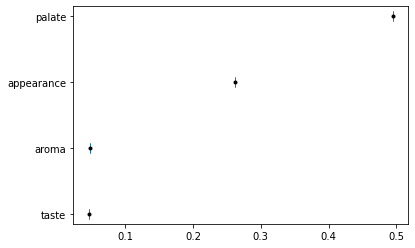

In [92]:
plt.errorbar(l1, np.array(range(len(l1))), xerr = l3,linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.yticks(range(len(l2)),l2);

#### Interpreation

We can see that there is a significant correlation between the rating of the four attributes and the final rating. However it seems that the palate have a higher impact with a coefficient being equals to 0.5.

### Regression analysis agregated by country

First we filter the reviews dataframe to only keep the countries with more than 100 reviews so the analysis are representative.

In [93]:
filter_country = reviews.groupby('user_country').rating.count().apply(lambda x : True if x>100 else False)

In [94]:
reviews_filtered_country = reviews.drop(reviews[reviews['user_country'].isin(filter_country[filter_country == False].index)].index)

print(f'{len(reviews)-len(reviews_filtered_country)} rows were droped. Because {len(filter_country[filter_country == False])}\
countries have less than 100 reviews : \n {list(filter_country[filter_country == False].index)}')

2387 rows were droped. Because 93countries have less than 100 reviews : 
 ['abkhazia', 'afghanistan', 'albania', 'algeria', 'american samoa', 'antigua and barbuda', 'armenia', 'aruba', 'azerbaijan', 'bangladesh', 'barbados', 'belize', 'bhutan', 'bosnia and herzegovina', 'botswana', 'bouvet island', 'british indian ocean territory', 'burkina faso', 'burundi', 'cayman islands', 'costa rica', 'cuba', 'dem rep of congo', 'east timor', 'egypt', 'falkland islands', 'fiji islands', 'french guiana', 'ghana', 'guatemala', 'guernsey', 'haiti', 'hawaii', 'honduras', 'iran', 'iraq', 'isle of man', 'ivory coast', 'jamaica', 'kenya', 'kosovo', 'kyrgyzstan', 'laos', 'lebanon', 'liechtenstein', 'macau', 'macedonia', 'malta', 'mauritania', 'mauritius', 'monaco', 'mongolia', 'montenegro', 'montserrat', 'morocco', 'nagorno-karabakh', 'namibia', 'nepal', 'new caledonia', 'nicaragua', 'nigeria', 'norfolk island', 'northern mariana islands', 'oman', 'pakistan', 'palestine', 'papua new guinea', 'paraguay', '

Then we create a function wich compute the regression analysis for each country and stores the important results in a dataframe.

In [95]:
def ols_attibute_country(df):
    dict_country={'country':[],'variables':[],'coefficients':[],
                  'p_values':[] ,'standard_errors':[]}
    
    for country in list(df.user_country.unique()):
        dict_country['country'].append(str(country))
        
        mod_attributes = smf.ols(formula='rating ~ appearance + aroma + palate + taste', data=df[df['user_country']==country])
        np.random.seed(2)
        res_attributes = mod_attributes.fit()
        
        dict_country['variables'].append(list(res_attributes.params.index))
        dict_country['coefficients'].append(list(res_attributes.params.values))
        dict_country['p_values'].append(list(res_attributes.pvalues))
        dict_country['standard_errors'].append(list(res_attributes.bse.values))
        
        df_return = pd.DataFrame(data=dict_country).explode(['variables', 'coefficients', 'p_values', 'standard_errors']).reset_index(drop=True)
        
    return df_return

In [96]:
df_ols_country = ols_attibute_country(reviews_filtered_country)

Then we can visualize the results of the p-value and coefficients for each attribute accross all the countries. Resulting to an intersting distribution for the coefficient.

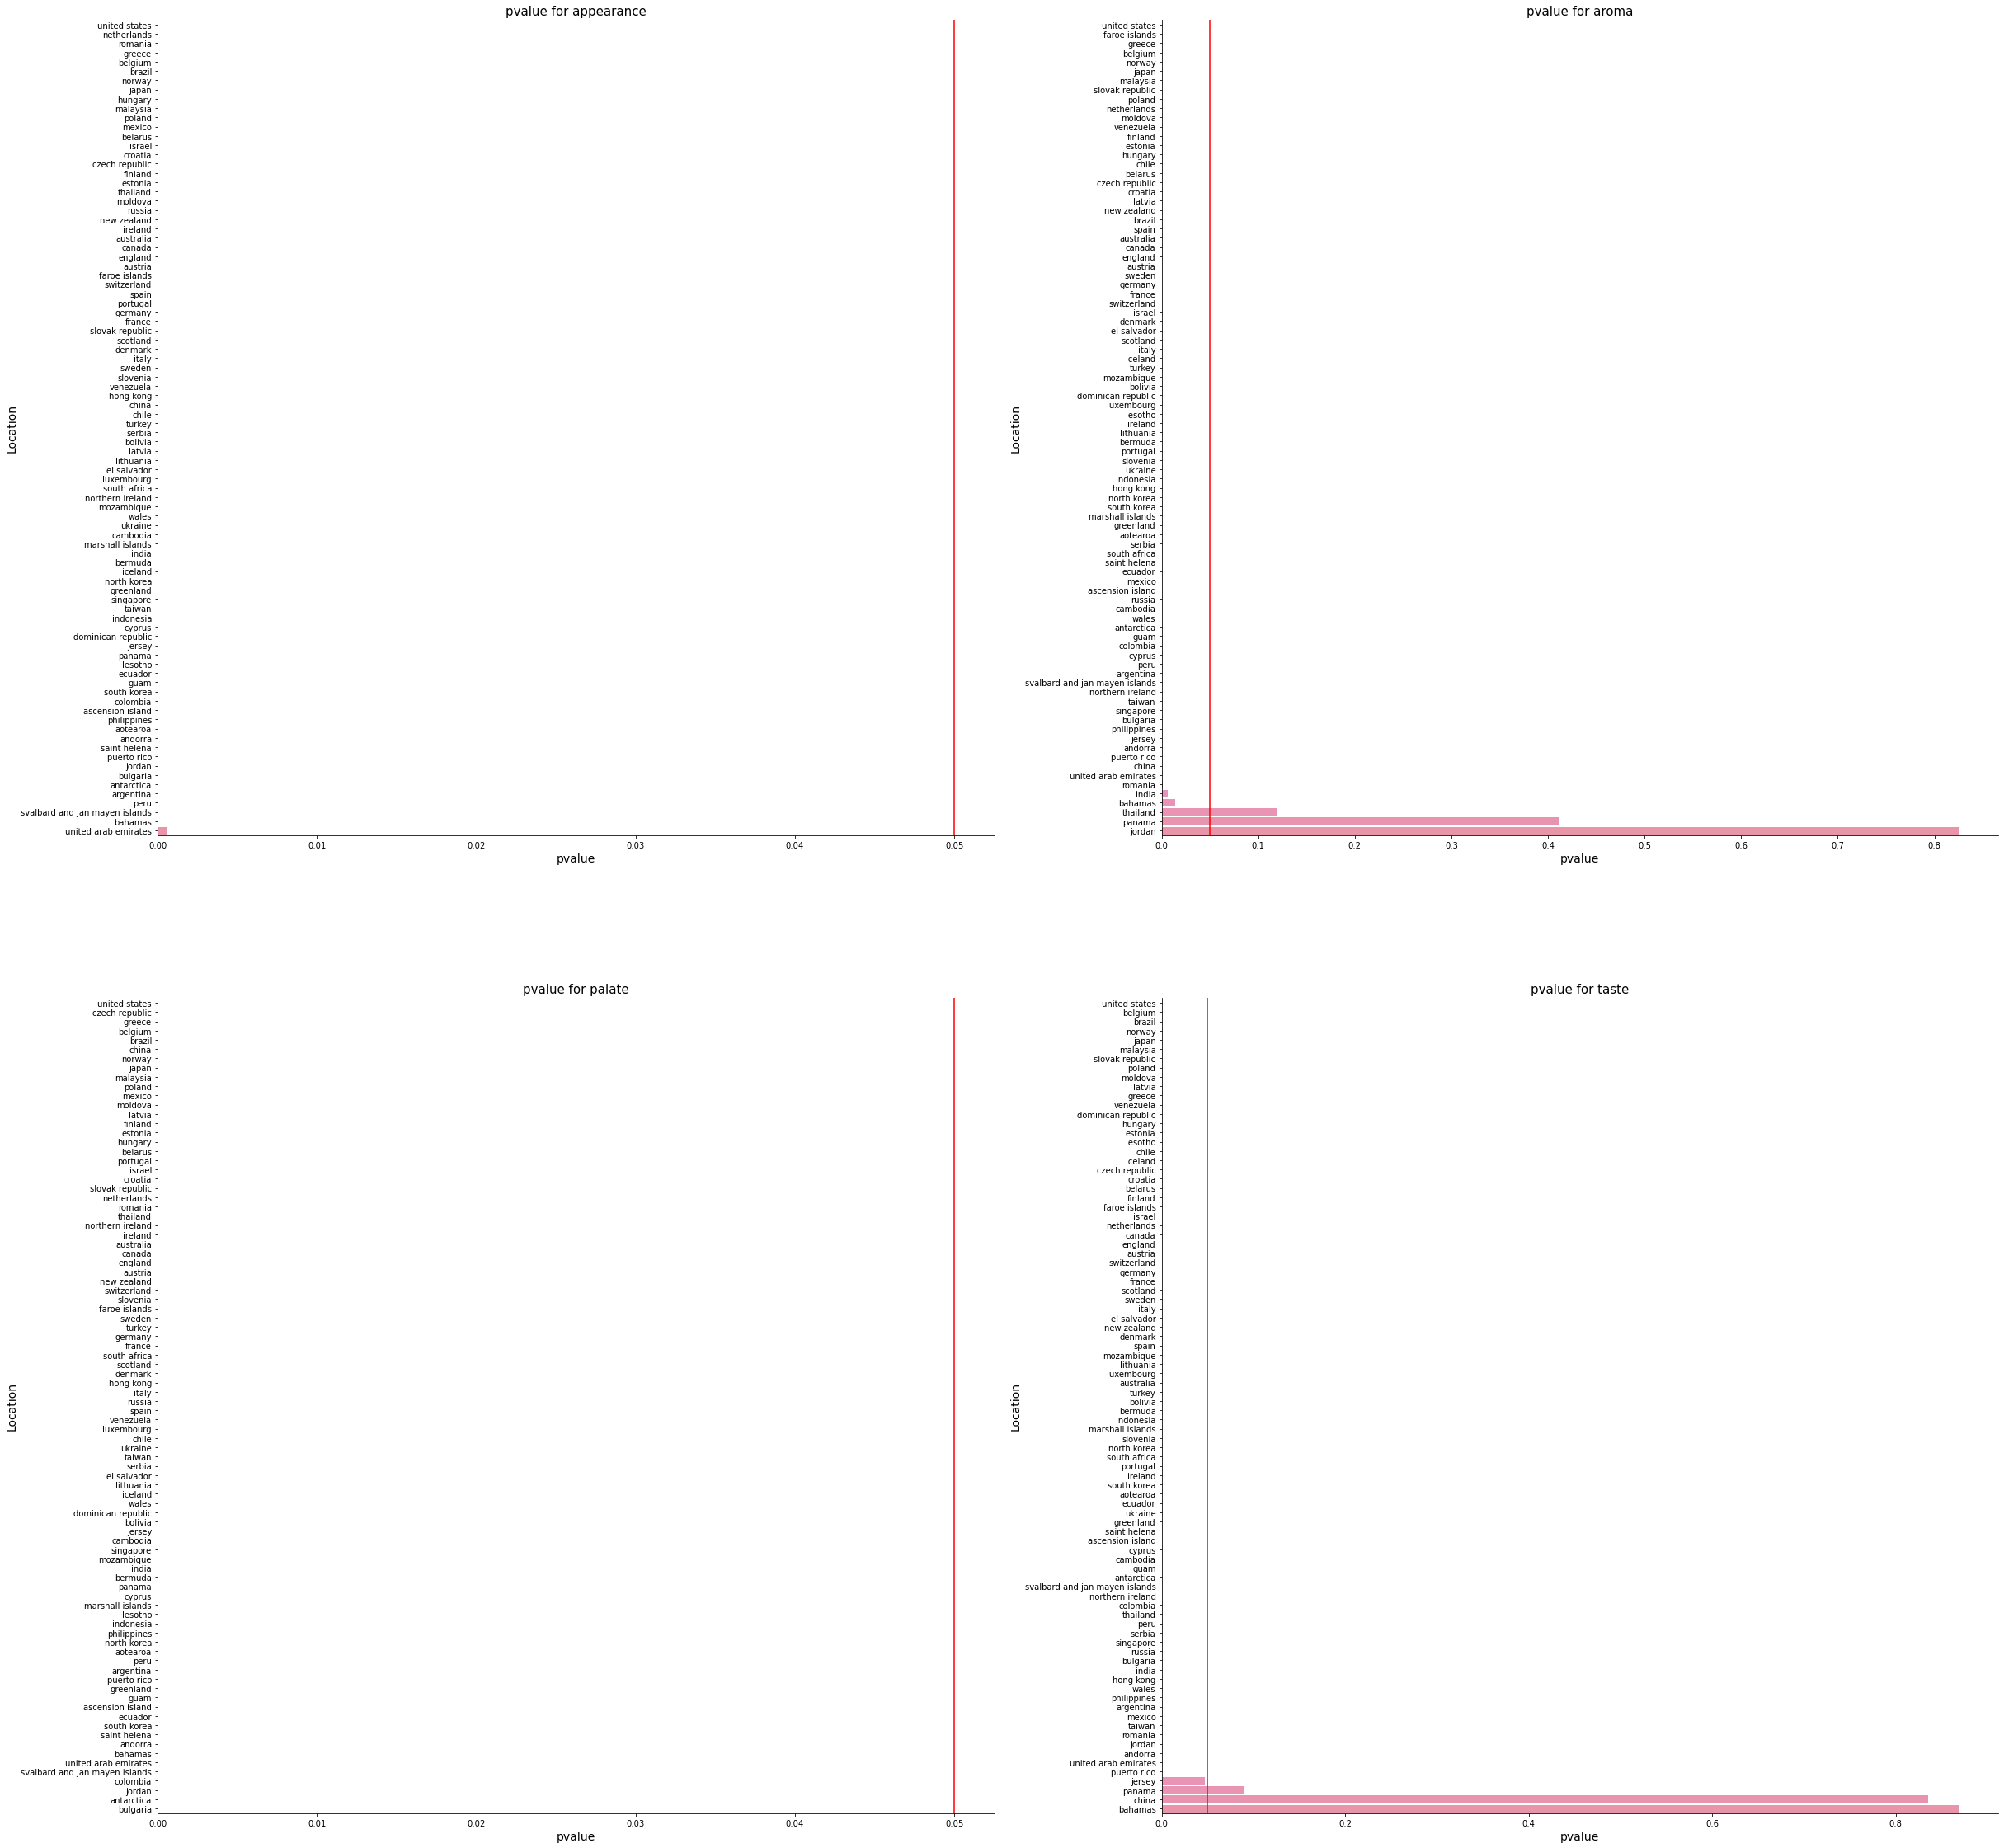

In [97]:
fig, axs = plt.subplots(2, 2, figsize=(40, 40))
ax = (axs[0, 0],axs[0, 1],axs[1, 0],axs[1, 1])
for idx,att in enumerate(beer_attributes):
    sns.barplot(data=df_ols_country, x=df_ols_country[df_ols_country['variables']==att].p_values, y=df_ols_country[df_ols_country['variables']==att].sort_values('p_values').country, ax=ax[idx])
    ax[idx].axvline(x = 0.05, color = 'r')
    ax[idx].set_title(f"pvalue for {att}", fontsize = 15)
    ax[idx].set_xlabel("pvalue", fontsize = 14)
    ax[idx].set_ylabel("Location", fontsize = 14)
    
    ax[idx].spines['right'].set_visible(False)
    ax[idx].spines['top'].set_visible(False)

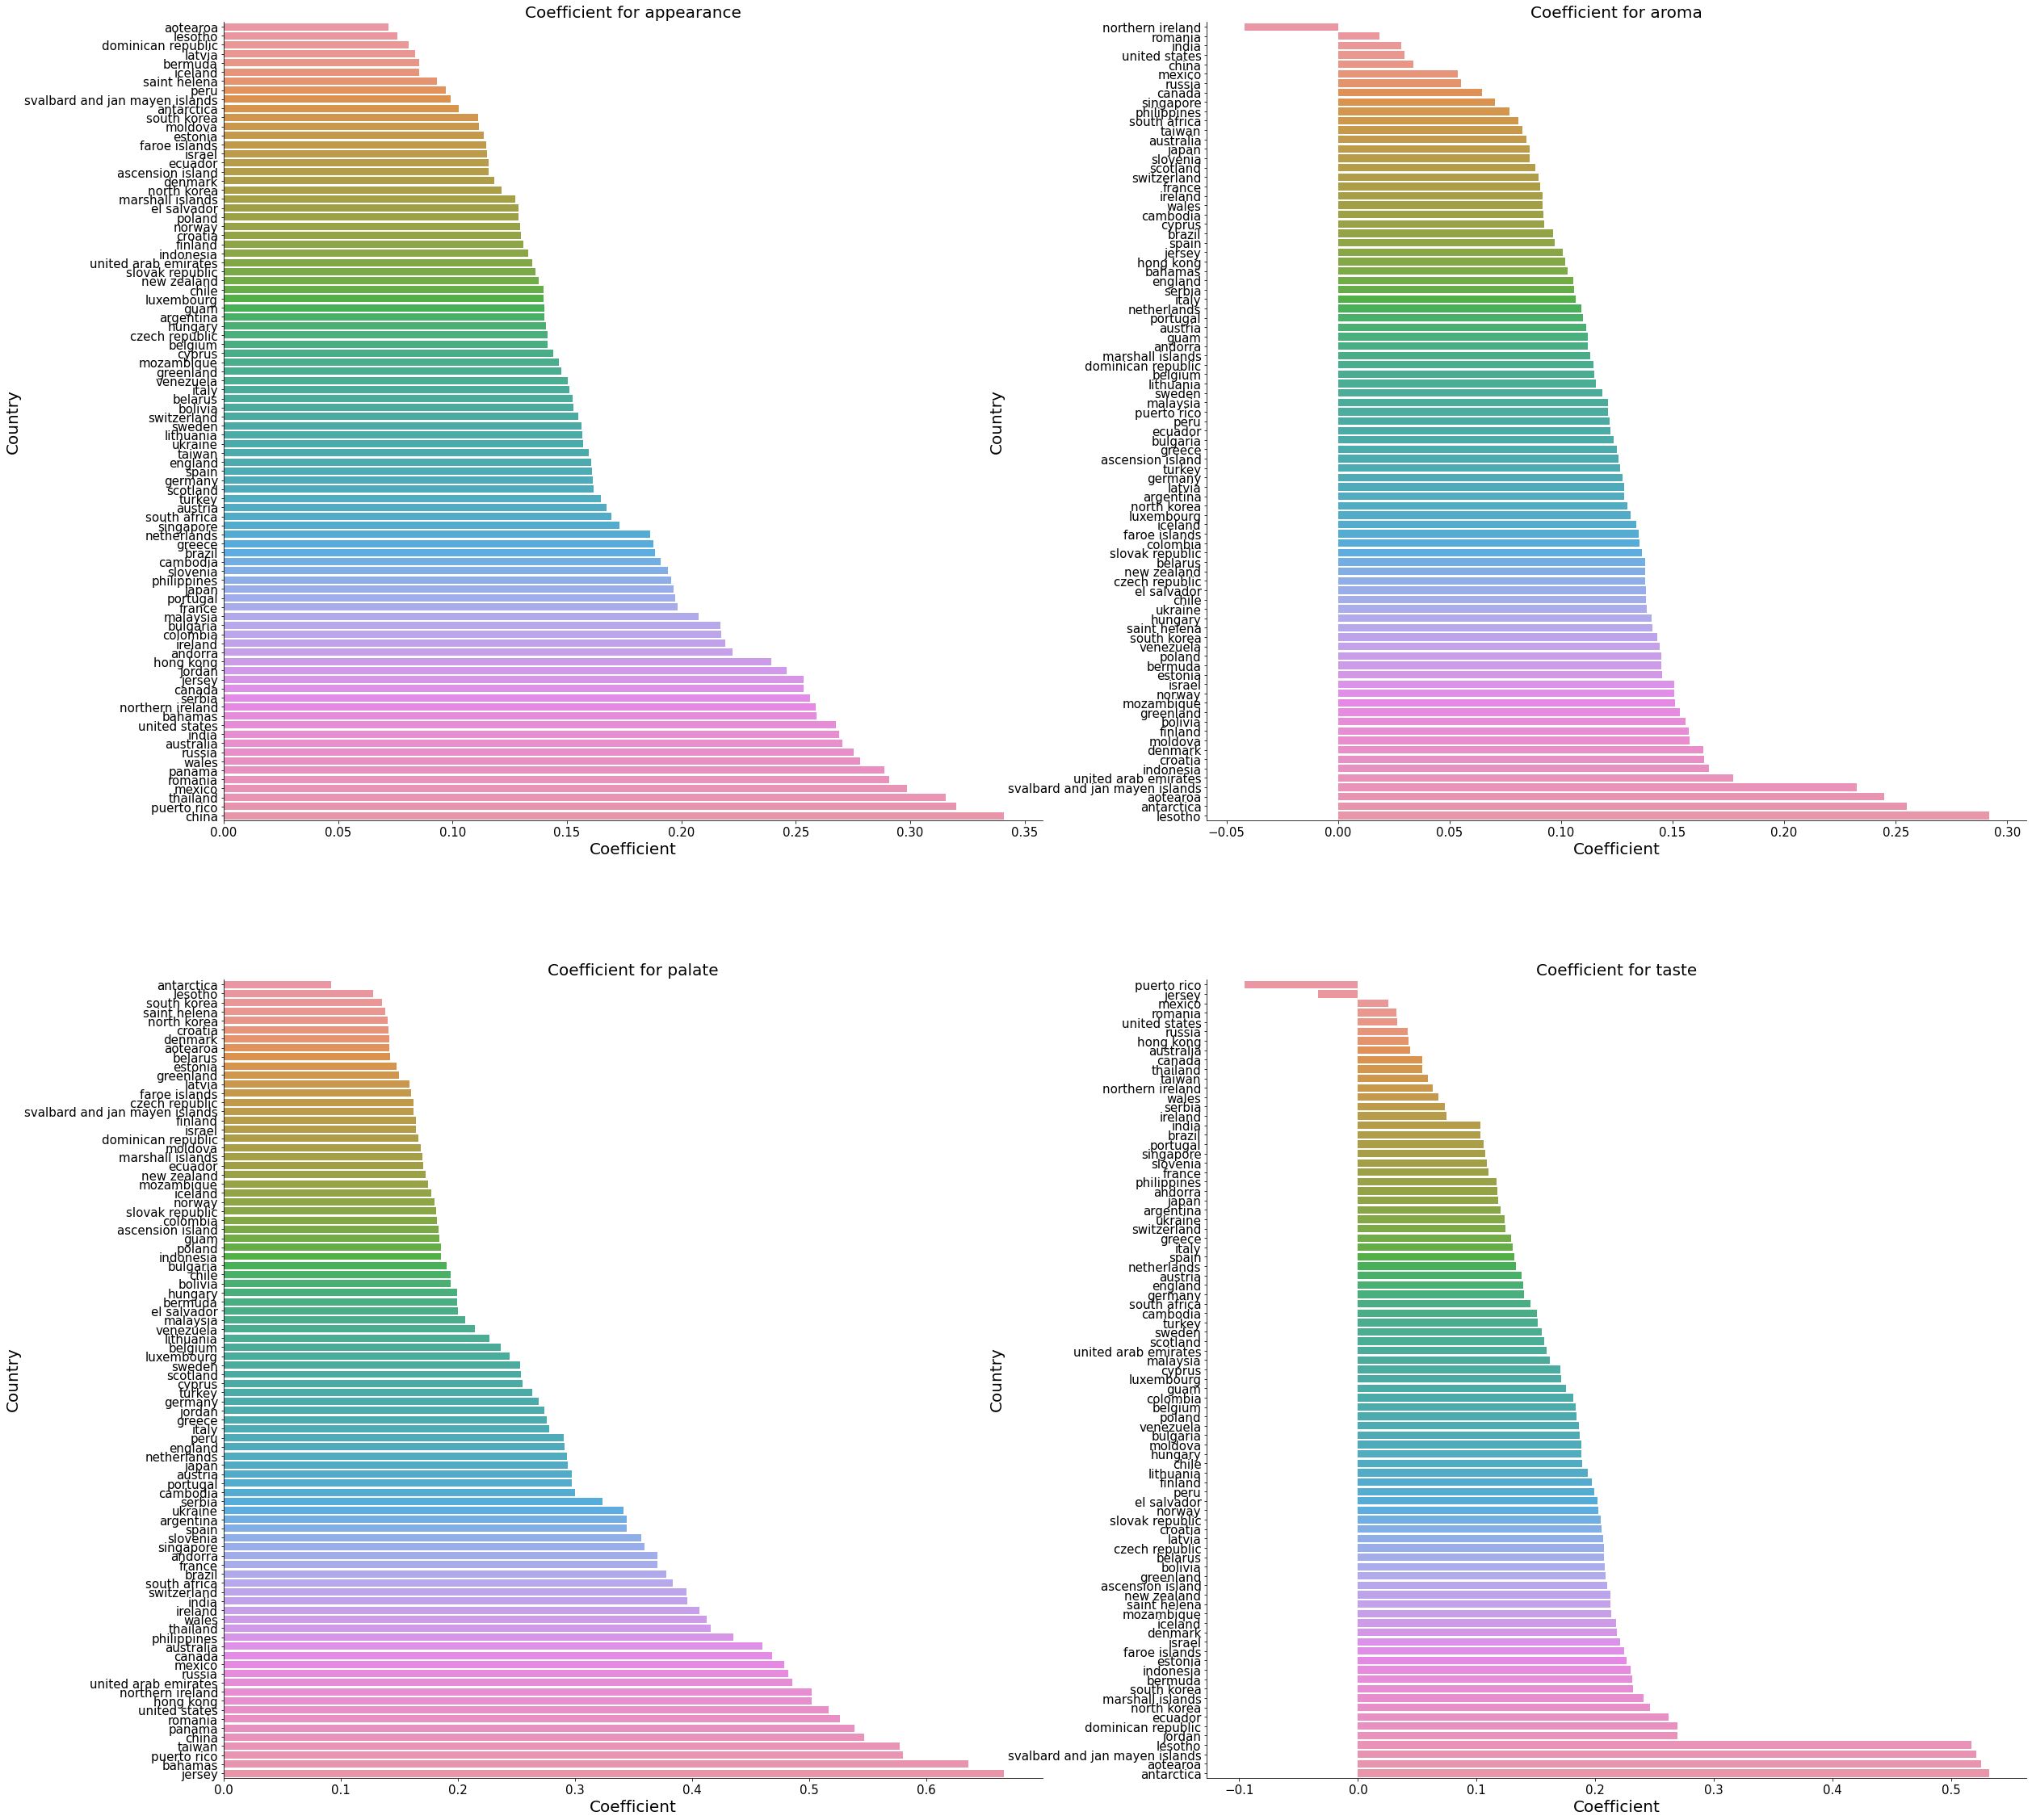

In [98]:
fig, axs = plt.subplots(2, 2, figsize=(40, 40))
ax = (axs[0, 0],axs[0, 1],axs[1, 0],axs[1, 1])

for idx,att in enumerate(beer_attributes):
    x = df_ols_country[(df_ols_country['variables']==att) & (df_ols_country['p_values']<0.05)].coefficients
    y= df_ols_country[(df_ols_country['variables']==att) & (df_ols_country['p_values']<0.05)].sort_values('coefficients')['country']
    
    sns.barplot(data=df_ols_country, x=x, y=y, ax=ax[idx])
    ax[idx].set_title(f"Coefficient for {att}", fontsize = 20)
    ax[idx].set_xlabel("Coefficient", fontsize = 20)
    ax[idx].set_ylabel("Country", fontsize = 20)
    
    ax[idx].tick_params(axis='both', which='major', labelsize=15)
    ax[idx].spines['right'].set_visible(False)
    ax[idx].spines['top'].set_visible(False)

#### Interpretation

Overall concerning all the country analized the four attributes has a correlation with the final rating given. However this not the case for Panama, Jordan, Thailand regarding the aroma and China, Panama the Bahamas regarding the taste.
Concerning the impact we can see that the coefficient is always positive but may vary depending the country. Showing that some country give more importance to a particular attribute than other countries. There is however 3 negatives coefficient which mean in general that if the rate of this particular attribute rise it will decrease the final rating. This concerns Nrthern Ieland for the aroma and Perto Rico and Jersey for the taste. We can group the coefficients in two groups based on their max coefficient. 

1) Group 1 : palate and taste
2) Group 2 : aroma and appearance

### Regression analysis agregated by style of beers

We repeat what we have done for the countries but now based on the beers style.

In [99]:
filter_style = reviews.groupby('style').rating.count().apply(lambda x : True if x>100 else False)

In [100]:
reviews_filtered_style = reviews.drop(reviews[reviews['style'].isin(filter_style[filter_style == False].index)].index)
print(f'{len(reviews)-len(reviews_filtered_style)} rows were droped. Because {len(filter_style[filter_style == False])} styles have less than 100 reviews : \n {list(filter_style[filter_style == False].index)}')

612 rows were droped. Because 10 styles have less than 100 reviews : 
 ['Saké - Futsu-shu', 'Saké - Genshu', 'Saké - Ginjo', 'Saké - Honjozo', 'Saké - Infused', 'Saké - Koshu', 'Saké - Namasaké', 'Saké - Nigori', 'Saké - Taru', 'Saké - Tokubetsu']


In [101]:
reviews_filtered_style.head()

,beer_id,brewery_id,style,user_id,rating,beer_name,user_name,appearance,aroma,palate,taste,overall,user_country,brewery_country,is_same_country
0,19445.0,37262.0,Euro Pale Lager,nmann08.184925,2.88,Régab,nmann08,3.25,2.75,3.25,2.75,3.0,united states,gabon,0
1,19590.0,10093.0,English Pale Ale,stjamesgate.163714,3.67,Barelegs Brew,StJamesGate,3.00,3.50,3.50,4.00,3.5,united states,northern ireland,0
2,19590.0,10093.0,English Pale Ale,mdagnew.19527,3.73,Barelegs Brew,mdagnew,4.00,3.50,3.50,4.00,3.5,northern ireland,northern ireland,1
3,19590.0,10093.0,English Pale Ale,helloloser12345.10867,3.98,Barelegs Brew,helloloser12345,4.00,3.50,4.00,4.00,4.5,northern ireland,northern ireland,1
4,19590.0,10093.0,English Pale Ale,cypressbob.3708,4.00,Barelegs Brew,cypressbob,4.00,4.00,4.00,4.00,4.0,northern ireland,northern ireland,1


In [102]:
def ols_attibute_type(df):
    dict_style={'style':[],'variables':[],'coefficients':[],
                  'p_values':[] ,'standard_errors':[]}
    
    for country in list(df['style'].unique()):
        dict_style['style'].append(str(country))
        
        mod_attributes = smf.ols(formula='rating ~ appearance + aroma + palate + taste', data=df[df['style']==country])
        np.random.seed(2)
        res_attributes = mod_attributes.fit()
        
        dict_style['variables'].append(list(res_attributes.params.index))
        dict_style['coefficients'].append(list(res_attributes.params.values))
        dict_style['p_values'].append(list(res_attributes.pvalues))
        dict_style['standard_errors'].append(list(res_attributes.bse.values))
        
        df_return = pd.DataFrame(data=dict_style).explode(['variables', 'coefficients', 'p_values', 'standard_errors']).reset_index(drop=True)
    
    return df_return

In [103]:
df_ols_type = ols_attibute_type(reviews_filtered_style)
df_ols_type

,style,variables,coefficients,p_values,standard_errors
0,Euro Pale Lager,Intercept,0.024727,0.0,0.003317
1,Euro Pale Lager,appearance,0.068217,0.0,0.001134
2,Euro Pale Lager,aroma,0.262231,0.0,0.001309
3,Euro Pale Lager,palate,0.153384,0.0,0.001331
4,Euro Pale Lager,taste,0.517318,0.0,0.001396
...,...,...,...,...,...
855,Saké - Junmai,Intercept,0.186821,0.002292,0.06068
856,Saké - Junmai,appearance,0.098991,0.0,0.013035
857,Saké - Junmai,aroma,0.171936,0.0,0.012885
858,Saké - Junmai,palate,0.127396,0.0,0.017732


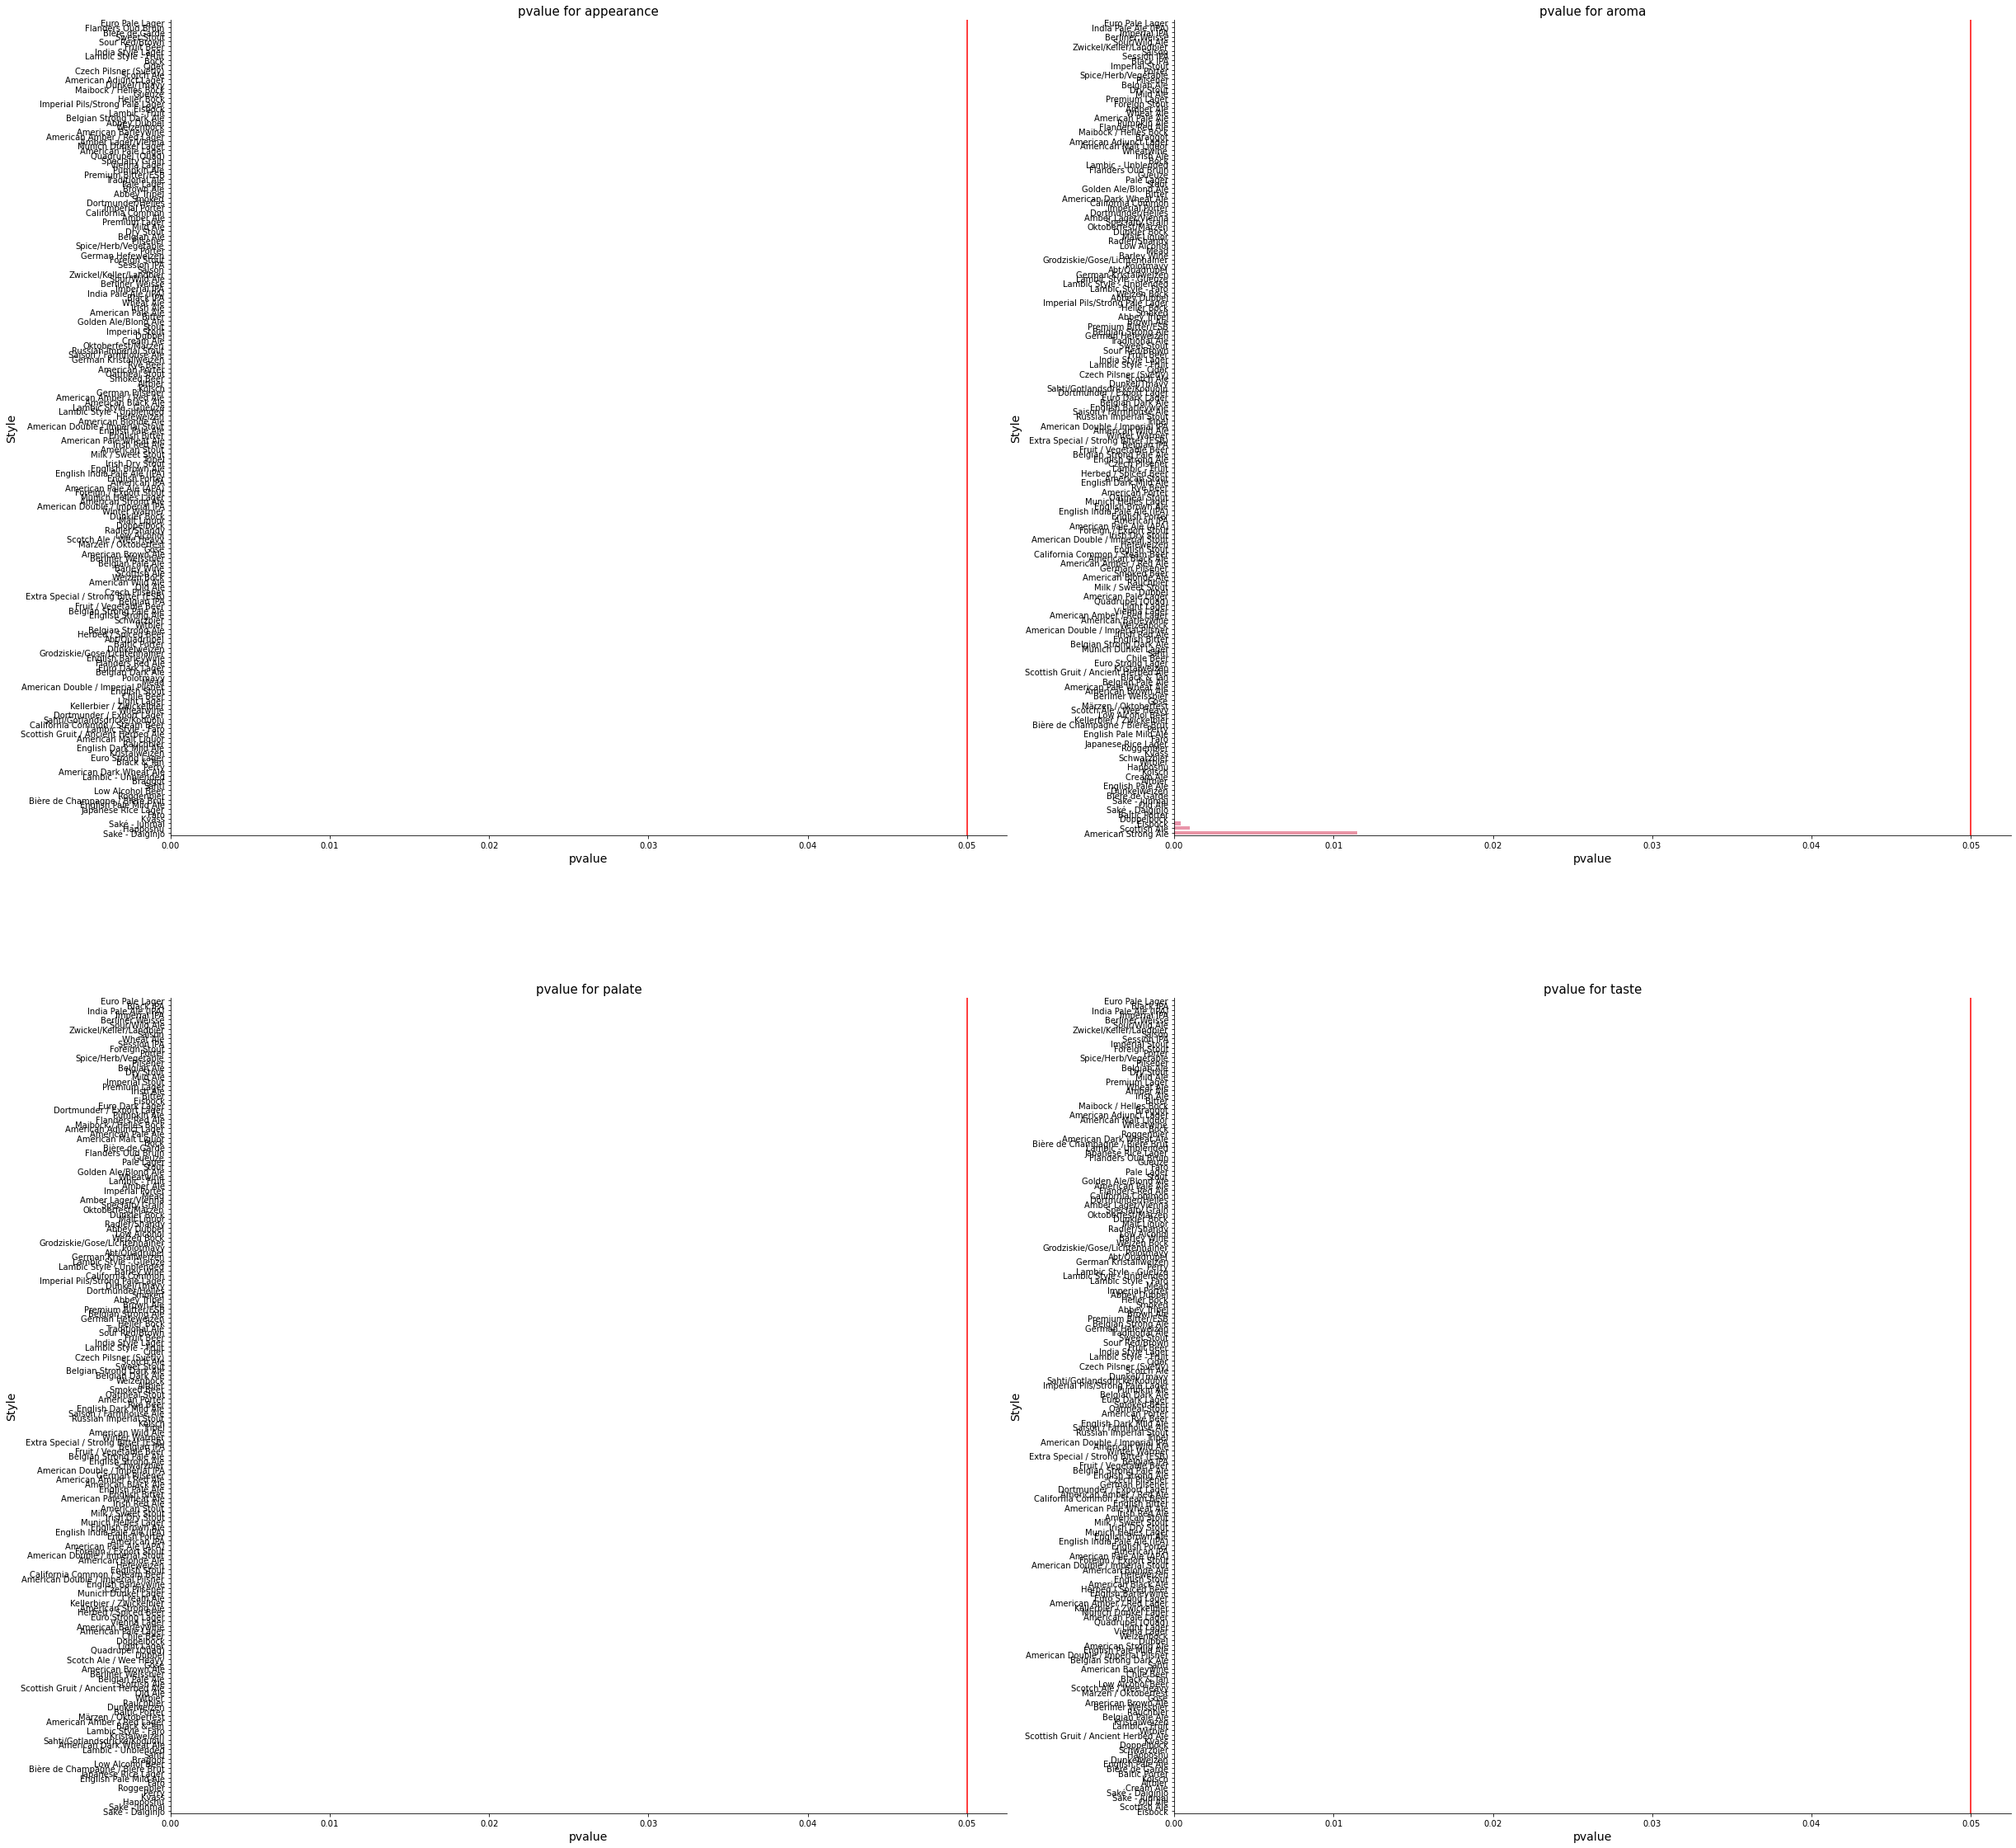

In [104]:
fig, axs = plt.subplots(2, 2, figsize=(40, 40))
ax = (axs[0, 0],axs[0, 1],axs[1, 0],axs[1, 1])
for idx,att in enumerate(beer_attributes):
    x = df_ols_type[df_ols_type['variables']==att].p_values
    y=df_ols_type[df_ols_type['variables']==att].sort_values('p_values')['style']

    sns.barplot(data=df_ols_type, x=x, y=y, ax=ax[idx])
    ax[idx].axvline(x = 0.05, color = 'r')
    ax[idx].set_title(f"pvalue for {att}", fontsize = 15)
    ax[idx].set_xlabel("pvalue", fontsize = 14)
    ax[idx].set_ylabel("Style", fontsize = 14)
    #ax[idx].bar_label(ax[idx].containers[0])
    ax[idx].spines['right'].set_visible(False)
    ax[idx].spines['top'].set_visible(False)

We can see that there is no p-value less than the 5% threshold. For the distribution of the linear regression coefficient of each attribute accros the beer style what is more interesting than just looking at each style it's the distribution by itself. 

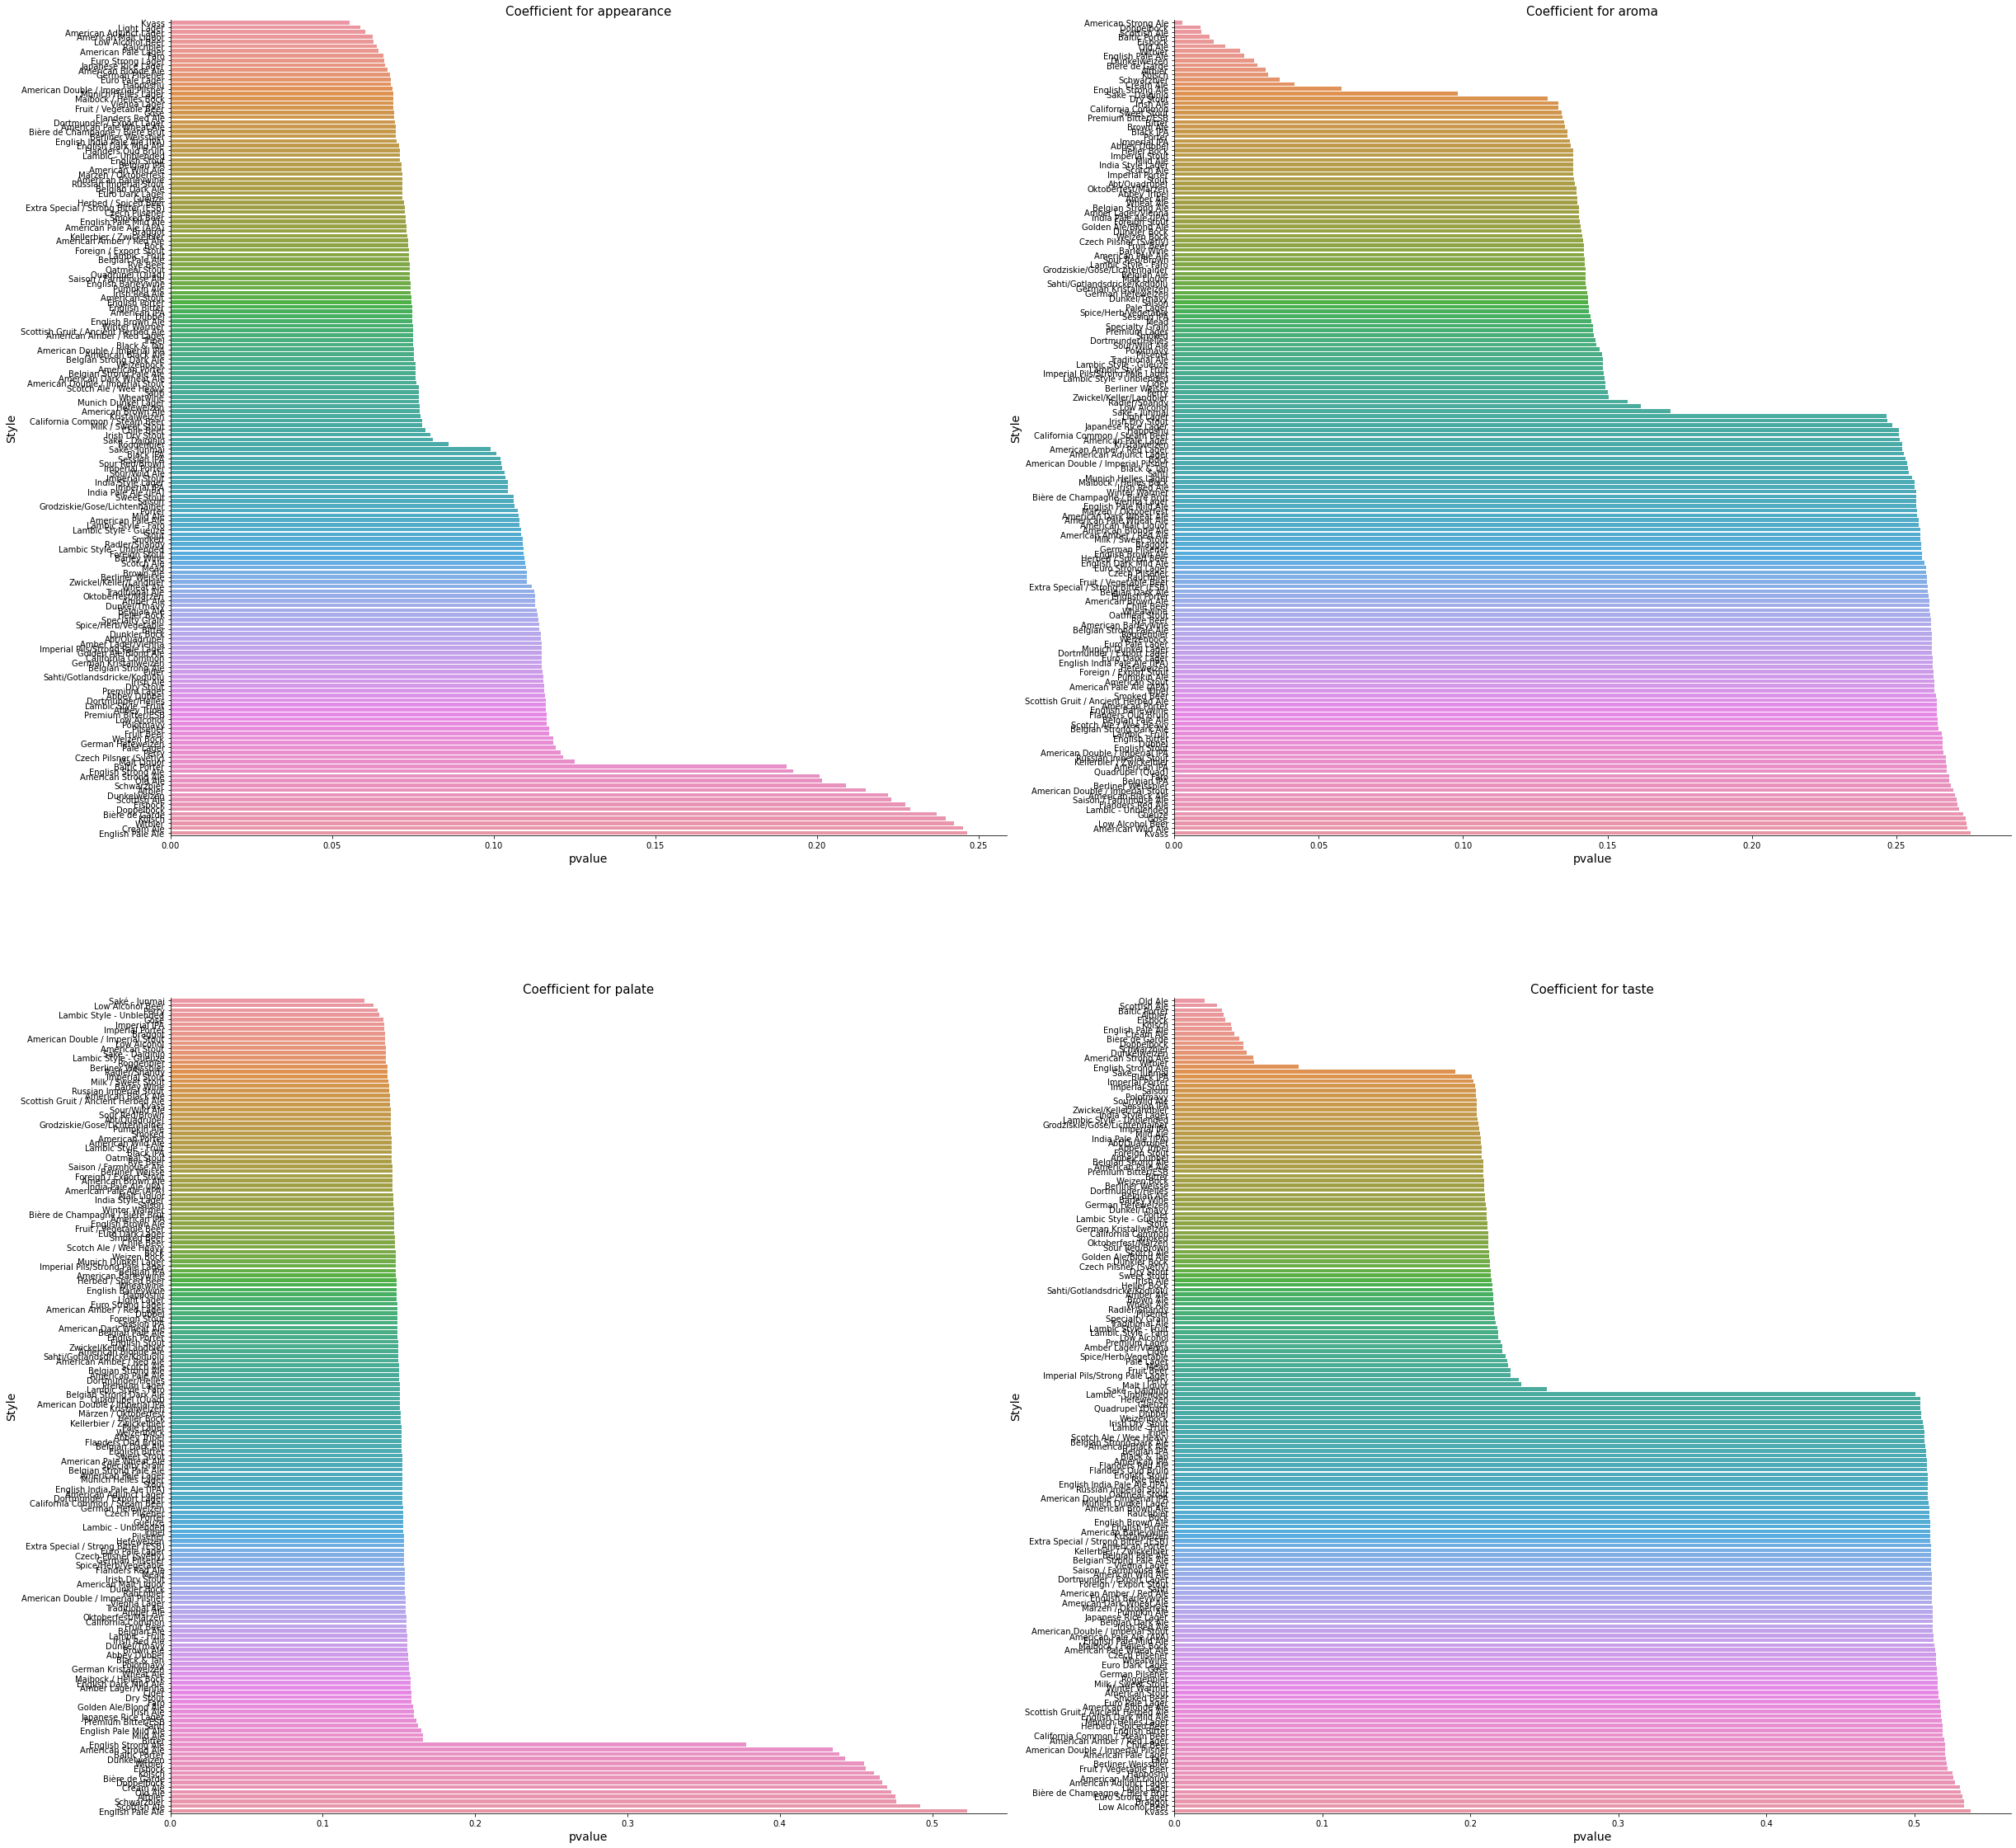

In [105]:
fig, axs = plt.subplots(2, 2, figsize=(40, 40))
ax = (axs[0, 0],axs[0, 1],axs[1, 0],axs[1, 1])
for idx,att in enumerate(beer_attributes):
    x = df_ols_type[(df_ols_type['variables']==att) & (df_ols_type['p_values']<0.05)].coefficients
    y= df_ols_type[(df_ols_type['variables']==att) & (df_ols_type['p_values']<0.05)].sort_values('coefficients')['style']
    
    sns.barplot(data=df_ols_type, x=x, y=y, ax=ax[idx])
    ax[idx].set_title(f"Coefficient for {att}", fontsize = 15)
    ax[idx].set_xlabel("Coefficient", fontsize = 14)
    ax[idx].set_ylabel("Style", fontsize = 14)
   
    ax[idx].spines['right'].set_visible(False)
    ax[idx].spines['top'].set_visible(False)

#### Interpretation

First of all, each attributes has a significant correlation for all the style of beers. Futhermore, we can see that there different styles "cluster" regarding the coefficients for the four attributes.

Appearance, aroma and taste seem to have three styles clusters.
Palate seems to have only two style cluster.

Like the previous analysis, we can see two groups of coefficients:
1) Group 1 : palate and taste
2) Group 2 : aroma and appearance

# 4.  Recommender system

Singular Value Decomposition (SVD) is a matrix factorization technique that is often used in the field of recommendation system to predict the ratings that users would give to items they have not yet rated.

In collaborative filtering, we try to predict the ratings that a user would give to an item based on the ratings that similar users have given to that item. One way to do this is to use SVD to decompose the ratings matrix into the product of three matrices: a user matrix, a singular matrix, and an item matrix.

The user matrix and the item matrix both contain latent factors that represent the preferences of the users and the characteristics of the items, respectively. These latent factors are derived from the ratings matrix through the SVD process.

To make a prediction for a given user and item, we can take the dot product of the latent factors for that user and item. This dot product gives us a predicted rating for the user-item pair.

The SVD method can be used to handle missing values in the ratings matrix, which is common in real-world recommendation systems where many users have not rated many items. By decomposing the ratings matrix into latent factors, we can fill in the missing values and make predictions for all the user-item pairs, even those that have not been rated.

### Sparsity

The user-based recommender system is based on the fact that two different users rated the same beer. But there is certainly a lot users with little or no shared ratings. Let's try to evaluate it by showing the perrcentage beers with less than 5 ratings.

In [106]:
(len(beers_ba[beers_ba.nbr_ratings<5])/len(beers_ba))*100

65.75921487912315

So there is 65.76% of beers with less than 5 reviews, which will of course impact the result of the recommender system. It will be bias and will have more probability to recommend the 34,24% beers because they have more reviews thus are more likely to be shared by two users.

### Scalability

There is no real way of dealing with that problem other than minimizing the recommender system algorithm coplexity. There is the possibility of trying different methods applications for the recommender system but here we will stick with the user-based collaborative filtering method.

### Filtering the dataset

To ensure that our recommender system will return meaningful information we get rid of the users and beers with less than 100 reviews. Thus, the user filtered can't have a beer recommended and the beer filtered can't be recommended. Futhermore due to lack of RAM and the ressources needed to run the recommender system we will only use 30% of all the dataset available.

In [107]:
len(reviews)

8580507

In [108]:
reviews = reviews.drop(reviews.sample(frac = 0.7).index)

In [109]:
len_before = len(reviews)
filter_user= reviews.groupby('user_id').rating.count().apply(lambda x : True if x>100 else False)
reviews = reviews.drop(reviews[reviews['user_id'].isin(filter_user[filter_user == False].index)].index)

In [110]:
print(f'{len_before-len(reviews)} rows were droped because {len(filter_country[filter_country == False])} users have less than 100 reviews.')

448205 rows were droped because 93 users have less than 100 reviews.


In [111]:
len_before = len(reviews)
filter_beer = reviews.groupby('beer_id').rating.count().apply(lambda x : True if x>100 else False)
reviews = reviews.drop(reviews[reviews['beer_id'].isin(filter_beer[filter_beer == False].index)].index)

In [112]:
print(f'{len_before-len(reviews)} rows were droped because {len(filter_beer[filter_beer == False])} beers have less than 100 reviews.')

1011625 rows were droped because 219167 beers have less than 100 reviews.


In [113]:
len(reviews)

301373

### SVD

We first start by creating a pivot table of the ratings data to have a bag of beers. Each row is an user and each colunm is a beer (high dimensionality!). Then we fill the missing values in a colunm with the mean rating of each beer. And finish by creating the prediction_df base on the SVD performed on the bag of beers matrix.

In [114]:
bag_of_beers = reviews.pivot_table(index='user_id', columns='beer_id', values='rating')

# Fill missing values with the mean rating for each item
bag_of_beers.fillna(bag_of_beers.mean(axis=0), inplace=True)

# Convert the pivot table to a sparse matrix
matrix = csr_matrix(bag_of_beers.values)

# Calculate the singular value decomposition of the matrix k is a paramater that can be changed
U, sigma, Vt = svds(matrix, k=50)

# Convert the singular values to a diagonal matrix
sigma = np.diag(sigma)

# Make predictions for all items
all_predictions = U.dot(sigma).dot(Vt)

# Convert the predictions to a dataframe
predictions_df = pd.DataFrame(all_predictions, columns=bag_of_beers.columns, index=bag_of_beers.index)

In [115]:
predictions_df.head()

beer_id,2.0,3.0,4.0,5.0,8.0,9.0,11.0,12.0,13.0,15.0,...,262801.0,266618.0,270727.0,287073.0,287903.0,289846.0,302292.0,312224.0,367485.0,379141.0
user_id,,,,,,,,,,,,,,,,,,,,,
39.0,2.769979,3.020084,2.881311,2.965567,2.308328,3.202864,3.489343,3.361309,3.234794,3.410730,...,3.782807,3.607736,3.758717,3.637744,3.486508,3.604499,3.573706,3.653837,3.909053,3.833519
46.0,2.809648,2.928585,2.966481,2.894603,2.676984,3.199346,3.526628,3.421302,3.325550,3.469292,...,3.815620,3.524677,3.758402,3.648363,3.458824,3.602274,3.584894,3.724711,3.914156,3.877001
63.0,2.689702,2.842723,2.885918,2.955571,2.242868,3.094253,3.471278,3.335002,3.198541,3.439789,...,3.802395,3.568266,3.751982,3.664763,3.490844,3.609922,3.638891,3.712889,3.924481,3.862921
69.0,2.720208,2.947070,2.921672,2.988165,2.618736,3.252594,3.495029,3.325899,3.246178,3.394564,...,3.783610,3.553829,3.749834,3.623988,3.511478,3.610931,3.612981,3.691526,3.927441,3.855759
154.0,2.687655,2.935145,2.931887,2.945007,2.596398,3.166988,3.545312,3.338486,3.300776,3.414073,...,3.784554,3.542860,3.747300,3.626934,3.521971,3.617220,3.638312,3.712734,3.937634,3.865188


Let's evaluate the prediction using RMSE.

In [116]:
error = np.sqrt(np.mean((predictions_df.values - bag_of_beers.values)**2))
print(f'RMSE: {error:.4f}')

RMSE: 0.0948


We can plot the top 10 beers based on the SVD prediction rating.

In [117]:
sorted_mean_ratings = predictions_df.mean(axis=0).sort_values(ascending=False)
top_10 = sorted_mean_ratings.head(10)
x = reviews.beer_name[reviews.beer_id.isin(list(top_10.index))].unique()[:10]
y = top_10.values

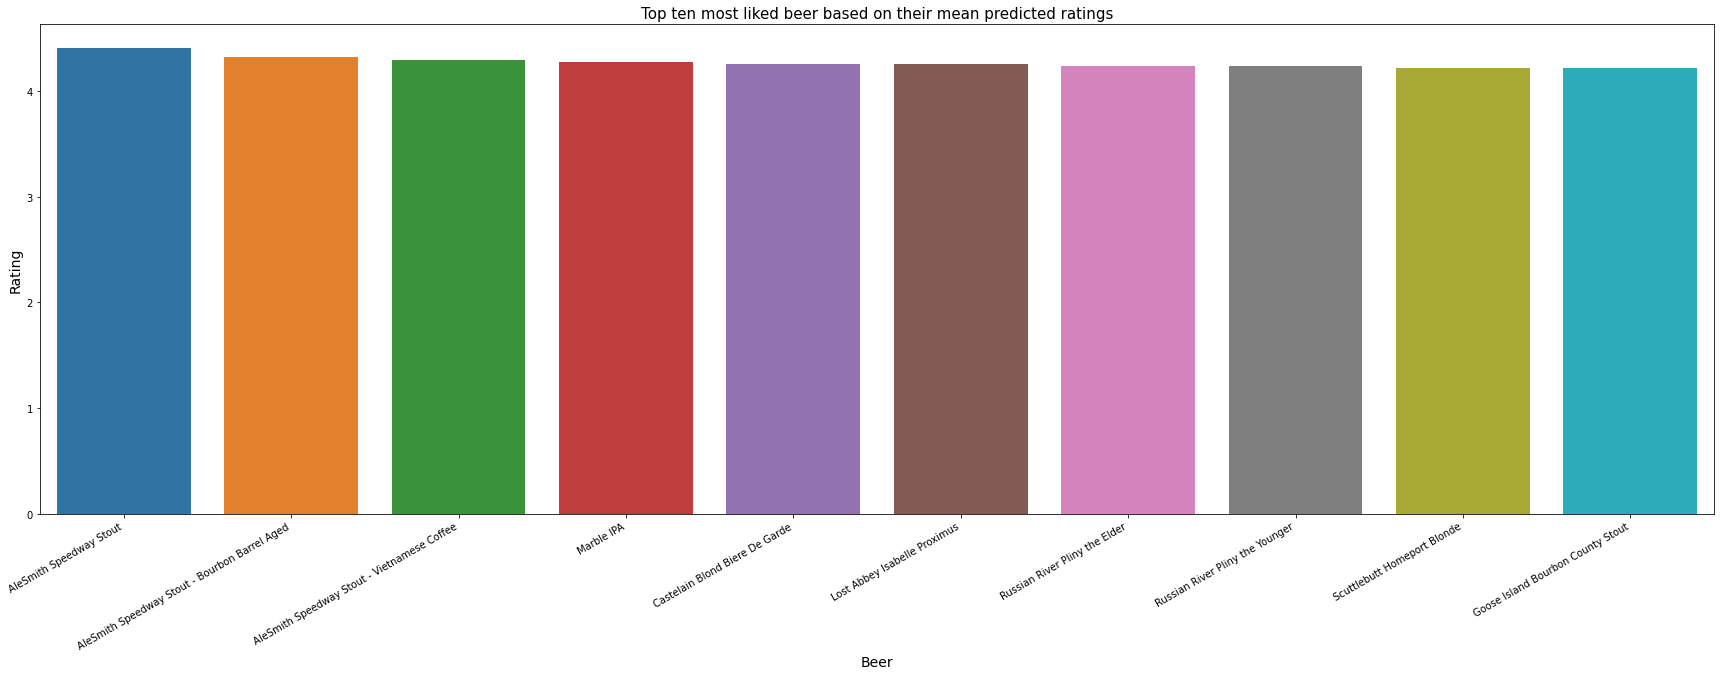

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(30, 10))


sns.barplot(data=predictions_df, x=x, y=y, ax=ax)
ax.set_title("Top ten most liked beer based on their mean predicted ratings", fontsize = 15)
ax.set_xlabel("Beer", fontsize = 14)
ax.set_ylabel("Rating", fontsize = 14)
fig.autofmt_xdate()

Now let's recommend.

In [119]:
def recommender(predictions_df, bag_of_beers, user_id):
    user_ratings = predictions_df.loc[user_id]
    already_rated = bag_of_beers.loc[user_id].dropna().index
    user_not_rated = user_ratings.drop(already_rated)
    best_item = user_ratings.sort_values(ascending=False).index[0]
    
    return best_item

In [120]:
random_user=bag_of_beers.sample().index[0]

recommended = recommender(predictions_df, bag_of_beers, random_user)
beer_name = reviews[reviews.beer_id==recommended].beer_name.values[0]
random_username = reviews[reviews.user_id==random_user].user_name.values[0]

print(f'For {random_username} our recommender system recommend this beer: {beer_name} \nEnjoy your drink !')

For nordic our recommender system recommend this beer: Westvleteren 12 (XII) 
Enjoy your drink !
